In [1]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys
import sympy as sy,imp
from tqdm import tqdm_notebook as tqdm
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize as op, measureroutine
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
mr = imp.reload(measureroutine)

In [2]:
afg = await connect('AFG')
await afg.query('*OPC?')

'1\n'

In [34]:
await afg.setValue('Output','ON',ch=1)
await afg.setValue('Function','Pulse',ch=1)
await afg.setValue('Pulse Period',250e-6,ch=1)
await afg.setValue('Pulse Width',1e-6,ch=1)
await afg.setValue('Amplitude',5,ch=1)
await afg.setValue('Offset',0,ch=1)
await afg.setValue('Burst Ncycles',1,ch=1)

In [4]:
await afg.getValue('Burst Ncycles',ch=1)

1.0

In [6]:
await afg.query('SOURce1:BURSt:STATe?')

'1\n'

In [35]:
for i in range(50):
    await afg.write('*TRG')
    time.sleep(1)

In [211]:
await afg.write('SOURce1:BURSt:STATe ON')

In [21]:
dpo = await connect('DPO190')
await dpo.query('*IDN?')

'TEKTRONIX,DPO71604C,C600317,CF:91.1CT FV:10.8.3 Build 3\n'

In [22]:
await dpo.query('TRIG:B:LEVEL:CH4?')

'1.8000E-3\n'

In [28]:
await dpo.query('TRIGGER:A:RUNT:SOURCE?')

QuLabRPCTimeout: Time out.

In [27]:
await dpo.write('TRIGGER:A:RUNT:SOURCE:CH4')

In [26]:
await dpo.query('ACQUIRE:STATE?')

'1\n'

# 链接仪器

In [88]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
#ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
# #psg102 = await connect('PSG102')
psg104 = await connect('PSG104')
#psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [3]:
await dc02.getValue('Offset')

-0.47344

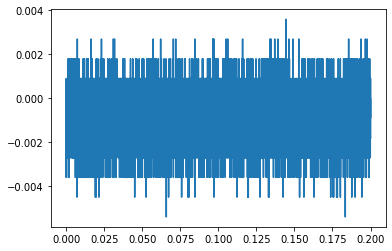

In [152]:
x,y = await dpo.get_Trace(ch=4)
plt.figure()
plt.plot(x,y)
plt.show()

In [1708]:
from qulab.sugar import getDHT

dht = await getDHT()
# await dht.set('PSG104','tcp://10.122.7.18:55259')
# await dht.get('ATS18')

In [44]:
from qulab.sugar import getDHT
dht = await getDHT()

name_inst = ['ATS18','AWG132','AWG131','AWG133','PSG101','PSG106','PSG104','DC01','DC02','DC03',\
             'DC04','DC05','DC06','DC07','DC08','DC10','DC11','DC15','DC20']
for i in name_inst:

    addr = await dht.get(i)
    print(i,addr)
#     if isinstance(addr,list):
#         addr = addr[0]
#     await dht.set(i,addr)

ATS18 tcp://10.122.7.18:51538


Got multiple values for key 1450591033247743550619776669419178069031125825857: ['tcp://10.122.7.18:53011', 'tcp://10.122.7.18:53011', 'tcp://10.122.7.18:50759']


AWG132 tcp://10.122.7.18:53011
AWG131 tcp://10.122.7.18:51340
AWG133 tcp://10.122.7.18:51341
PSG101 tcp://10.122.7.18:51338
PSG106 tcp://10.122.7.18:56084
PSG104 tcp://10.122.7.18:51342
DC01 tcp://10.122.7.18:51423
DC02 tcp://10.122.7.18:51437
DC03 tcp://10.122.7.18:51451


Got multiple values for key 1352497773066019371150282627368155415025680283394: ['tcp://10.122.7.18:51465', 'tcp://10.122.7.18:50960']


DC04 tcp://10.122.7.18:51465
DC05 tcp://10.122.7.18:51479
DC06 tcp://10.122.7.18:53232
DC07 tcp://10.122.7.18:51505
DC08 tcp://10.122.7.18:51515
DC10 tcp://10.122.7.18:51360
DC11 tcp://10.122.7.18:51380
DC15 tcp://10.122.7.18:51395
DC20 tcp://10.122.7.18:51409


In [54]:
dht = await getDHT()
await dht.set('PSG106','tcp://10.122.7.18:52302')

True

In [4]:
await dht.get('AWG133')

'tcp://10.122.7.18:51341'

# qubit工作点

In [3]:
f_cavity = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9

atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=0.067,f_ex=2*6.3e9+2e6,power_ex=-1.767) #power=-2.1

In [12]:
ch = [1,2,3,4,5,6,7,6,5,8]
awg_test = ['awg131','awg131','awg131','awg131','awg131','awg131','awg131','awg134','awg134','awg131',]

In [14]:
for i in range(1,11,1):
    instrument = globals()['q%d'%(i)].inst
    instrument['awg'] = awg_test[i-1]
    instrument['ch'] = ch[i-1]
    globals()['q%d'%(i)]._replace(inst=instrument)

In [438]:
q1= q1._replace(T_bias=[2.058,0.305])

In [439]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'awg': 'awg131', 'ch': 1}, T_bias=[2.058, 0.305], bias=-0.28, zpulse=None, f_lo=6554840000.0, delta=array([50000000.]), f_ex=array([3.62e+09]), delta_ex=array([80000000.]), power_ex=15, pi_len=65, T1=None)

## 保存qubit状态

In [65]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

## 提取Qubit工作点

In [4]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0329\QubitState\qubitstate_20200329130059.npz


In [5]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.1, zpulse=None, f_lo=array([6.53062e+09]), delta=array([50000000.]), f_ex=array([3.805e+09]), delta_ex=array([0]), power_ex=30, power_rabi=13, pi_len=25.1, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': -0.1, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 1.0525, 'load': 'high Z'}, 'dc15': {'offset': 0.0, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.580620GHz', 'power': '13.000000dBm', 'output'

## 指定仪器

In [89]:
psg_lo = psg104
psg_ex = psg105
psg_pump = psg101
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg133':awg133,'awg134':awg134}

In [425]:
for i in dc:
    z = eval((await dc[i].query('OUTP:LOAD?')).strip('\n'))
    if z != 50:
        z = 'high Z'
    print(i,z)

dc01 high Z
dc02 high Z
dc03 50.0
dc05 high Z
dc06 high Z
dc07 high Z
dc08 high Z
dc10 high Z
dc11 high Z
dc15 high Z
dc20 high Z


In [423]:
x = [dc01,dc02,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20]
for i in x:
    await i.write('OUTP:LOAD %s'%'INF')

## 腔频率设置

In [6]:
async def resn(f_cavity):
    f_lo = f_cavity.max() + 50e6
    delta =  f_lo - f_cavity 
    n = len(f_cavity)
    return f_lo, delta, n

In [71]:
#f_cavity = np.array([6.459,6.471,6.482,6.497,6.513,6.518,6.524,6.541,6.568,6.581])*1e9
f_cavity = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.60,6.605,6.63])*1e9
f_cavity = np.array([6.53])*1e9 
#f_cavity = np.array([6.605])*1e9
f_lo, delta, n = await resn(f_cavity)

In [73]:
delta

array([80000000., 75000000., 50000000.])

In [107]:
await mr.modulation_read(ats,awg133,delta,tdelay=1500)
await mr.ats_setup(ats,delta,l=1500)
f_list = await ats.getValue('f_list')
f_list

array([80000000., 75000000., 50000000.])

# CrossTalk_Cali

In [249]:
#data = np.load(r'D:\QuLabData\2019\0907\xue_crosstalk_20190907171937.npz')
#data = np.load(r'D:\QuLabData\2019\1213\crosstalk_cali\q3-q5_20191213002118.npz')
data=np.load(r'D:\QuLabData\2019\1218\crosstalk_cali\q1-q10_final_20191218010637.npz')
mat = data['mat']
#I0 = data['I0']
#mat
mat1 = mat[0:5,0:5]
#mat1 = M
#最终加在qubits上的电流为I = mat_crosstalk.I*[0,0,0,0,1]+I0

In [38]:
#mat = [[1.        ,- 0.02103294, 0.0385861 ],[0.17216009, 1.        , -0.04590398],[-0.15416957, - 0.08602858,  1.        ]]
#bias_cross = np.mat(mat1).I * np.mat([0,0,0,0,0,0,0,0,0,0]).T
bias_cross = np.mat(mat1).I * np.mat([0,0,1,0,0]).T
bias_cross

matrix([[-0.00203862],
        [ 0.01001766],
        [ 0.99925906],
        [-0.0262643 ],
        [-0.0147013 ]])

In [250]:
bias_cross1 = np.mat(mat1).I * np.mat([-0.3,-0.285,-0.225,-0.238,-0.225]).T  #-0.9,-0.8,-0.8,-0.8,-0.9
bias_cross1

matrix([[-0.32975214],
        [-0.24681979],
        [-0.16885131],
        [-0.16928893],
        [-0.15065259]])

In [251]:
for i in range(5):
    await dc[locals()['q%d'%(i+1)].inst['dc']].DC(bias_cross1[i])

## awg

In [165]:
bias_cross1 = np.mat(mat1).I * np.mat([0.45,0.95,-0.6,0.37,-0.65]).T   #-0.9,-0.8,-0.8,-0.8,-0.9
bias_cross1

matrix([[ 0.46421133],
        [ 0.93150119],
        [-0.62462855],
        [ 0.34791425],
        [-0.66631098]])

In [167]:
for i in range(5):
    await awg131.setValue('Offset',bias_cross1[i][0,0],ch=locals()['q%d'%(i+1)].inst['ch'])

In [168]:
for i in range(5):
    chanel = locals()['q%d'%(i+1)].inst['ch']
    x= await awg131.getValue('Offset',ch=chanel)
    print(chanel,x)

1 0.464
2 0.932
3 -0.625
4 0.348
5 -0.666


In [157]:
0.5*750

375.0

In [205]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'awg': 'awg131', 'ch': 3}, T_bias=[1.716, 0.043], bias=-0.225, zpulse=None, f_lo=6580640000.0, delta=array([50000000.]), f_ex=array([3.727e+09]), delta_ex=array([80000000.]), power_ex=15.5, pi_len=array([60.8]), T1=None)

In [206]:
q4

qubit(q_name='q4', inst={'dc': 'dc11', 'awg': 'awg131', 'ch': 4}, T_bias=[1.705, 0.014], bias=-0.252, zpulse=None, f_lo=6593840000.0, delta=array([50000000.]), f_ex=array([3.732e+09]), delta_ex=array([80000000.]), power_ex=16.5, pi_len=array([64.4]), T1=None)

In [477]:
i = -0.25
c0, c1, c2, c3, c4 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3],i*bias_cross[4]
await dc[q1.inst['dc']].DC(c0+bias_cross1[0]) 
await dc[q2.inst['dc']].DC(c1+bias_cross1[1])
await dc[q3.inst['dc']].DC(c2+bias_cross1[2])
await dc[q4.inst['dc']].DC(c3+bias_cross1[3])
await dc[q5.inst['dc']].DC(c4+bias_cross1[4])


In [2024]:
j =0

current_points = np.array([0.19,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])
# for i in range(10):
#     await dc[locals()['q%d'%(i+1)].inst['dc']].DC(j*bias_cross[i]+bias_cross1[i])

# bias_cross = 0
# for k,v in enumerate(current_points):
#     zero = np.zeros(10)
#     zero[k] = v
#     bias_cross += np.mat(mat1).I * np.mat(zero).T

bias_cross = np.mat(mat1).I * np.mat(current_points).T

for i in range(10):
    await dc[locals()['q%d'%(i+1)].inst['dc']].DC(bias_cross[i])

In [2025]:
bias_cross

matrix([[ 0.14051177],
        [ 0.16625438],
        [-0.16675666],
        [ 0.78654913],
        [ 0.10520401],
        [ 0.08649123],
        [-0.08580955],
        [ 0.07462403],
        [ 0.07623546],
        [ 1.06053111]])

## 混AWG_IQ频率

In [8]:
t_list = np.linspace(0,4000,10000)
t_list = np.linspace(0,100000,250000)
delta_ex = [80e6]

In [27]:
async def modulation_read(awg,delta,n):
    #t_list = np.linspace(0,100000,250000)

    f, phi, t_end, width, height = [delta], [[0]*n], [[91000]], [[1000]], [[1]]
    wf = WF(t_list)
    await awg.create_waveform(name='Readout_Q', length=len(t_list), format=None)
    await awg.create_waveform(name='Readout_I', length=len(t_list), format=None)
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample/np.abs(sample).max(),name='Readout_Q')
    
    f, phi, t_end, width, height = [delta], [[np.pi/2]*n], [[91000]], [[1000]], [[1]]
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample/np.abs(sample).max(),name='Readout_I')
    
    sample = wf.square_wave(t_end=[91415],width=[1000],height=[1])
    await awg.update_marker(name='Readout_Q',mk1=sample)
    await awg.update_marker(name='Readout_I',mk1=sample)
    time.sleep(5)
    
await modulation_read(awg133,delta,n)

## 创建波形及sequence

In [4]:
x = {}
async def create_wavelist(dictname,kind,para):
    @Collect_Waveform(dictname,kind)
    async def create_waveformlist(awg,name,n_wave,length):
        name_list = []
        for i in tqdm(name,desc='create_waveformlist'):
            name_collect = []
            for j in range(1,n_wave+1):
                name_w = ''.join((name,'_%d'%j))
                name_collect.append(name_w)
                #await awg.create_waveform(name=name_w, length=length, format=None) 
            name_list.append(name_collect)
        return name_list
    return create_waveformlist(*para)

In [5]:
await create_wavelist(x,'T5',('awg132','z',4,10))

In [6]:
x

{'T5': [['z_1', 'z_2', 'z_3', 'z_4']]}

In [12]:
await awg.remove_waveform('test_Q')

In [14]:
async def wave(name_seq, choice=None):
    t, j = np.linspace(0, 500, 501), 0
    len_s = len(t)
    await awg.create_sequence(name_seq, len_s, 5)
    for i in tqdm(t, desc='sequence'):
        j += 1

        await awg.set_seq(wave_name='Readout_I',
                          step=j,
                          track=1,
                          seq_name=name_seq,
                          wait='ATR',
                          goto='NEXT',
                          repeat='1',
                          jump0='OFF',
                          jump1='NEXT')

        await awg.set_seq(wave_name='Readout_Q',
                          step=j,
                          track=2,
                          seq_name=name_seq,
                          wait='ITR',
                          goto='NEXT',
                          repeat='1',
                          jump0='OFF',
                          jump1='NEXT')

        await awg.set_seq(wave_name='Ex_I',
                          step=j,
                          track=3,
                          seq_name=name_seq,
                          wait='ATR',
                          goto='NEXT',
                          repeat='1',
                          jump0='OFF',
                          jump1='NEXT')

        await awg.set_seq(wave_name='Ex_Q',
                          step=j,
                          track=4,
                          seq_name=name_seq,
                          wait='ITR',
                          goto='NEXT',
                          repeat='1',
                          jump0='OFF',
                          jump1='NEXT')

        await awg.set_seq(wave_name='z',
                          step=j,
                          track=5,
                          seq_name=name_seq,
                          wait='ITR',
                          goto='NEXT',
                          repeat='1',
                          jump0='OFF',
                          jump1='NEXT')

In [15]:
await wave('common_vert')

In [8]:
async def sub_seq(awg,name_w):
    name_s = ''.join(('sub_',name_w))
    await awg.create_sequence(name_s,2,1)
    await awg.set_seq(wave_name=name_w,step=1,track=1,seq_name=name_s,
                          wait='OFF',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
    await awg.set_seq(wave_name='zero',step=2,track=1,seq_name=name_s,
                          wait='OFF',goto='FIRST',repeat='195',jump0='OFF',jump1='FIRST')
    return name_s

In [18]:
async def wave(awg,name_seq,w):
    y, j = np.linspace(-150,50,101), 0
    len_s = len(y)
    await awg.create_sequence(name_seq,len_s,1)
    wf = WF(t_list)
    for k in tqdm(y,ncols=1,desc='sequence'):
        j += 1
        name_w, name_seq, track = ''.join(('Ex_Q_5_','%d'%j)), name_seq, 1
        if k == 0 :
            beta = np.inf
        else:
            beta = w/k  
        #c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3]
        t = np.sqrt(k**2+w**2)   
        theta = np.arctan(beta)
        f,phi,height,t_end,width = [delta_ex,delta_ex],[[np.pi/2],[np.pi/2+theta]],[[1],[1]],[[2800-t],[2900]],[[pi_len/2],[t]]
        sample = wf.sin_envelope(f,phi,t_end,width,height)
        #await awg.remove_waveform(name=name_w)
        #await awg.remove_sequence(name=''.join(('sub_',name_w)))
        await awg.create_waveform(name=name_w, length=len(t_list), format=None)
        await awg.update_waveform(sample,name=name_w)
        name_s = await sub_seq(awg,name_w)
 

        if j == len_s:
            jump1 = 'FIRST'
        else:
            jump1 = 'NEXT'
        await awg.set_seq(wave_name=name_s,step=j,track=track,seq_name=name_seq,tag='subseq',
                            wait='ATR',goto='NEXT',repeat='INFinite',jump0='BTRigger',jump1=jump1)

In [599]:
async def update(w):
    wf = WF(t_list)
    volt = np.linspace(-0.8,0,81)
    j = 0
    for i in volt:
        j += 1
        name0,name1,name2,name3 = ''.join(('z0_','%d'%j)),''.join(('z1_','%d'%j)),''.join(('z5_','%d'%j)),''.join(('z3_','%d'%j))
            
        c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3]
            
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c0)],[89900],[w]
        #sample0 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample0,name=name0)
        
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c1)],[89900],[w]
        #sample1 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample1,name=name1)
        
        f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[i],[89900],[w]
        sample2 = wf.square_wave(t_end,width,height)
        await awg.update_waveform(sample2,name=name2)
        
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c3)],[89900],[w]
        #sample3 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample3,name=name3) 
        #await awg.query('*OPC?')

## 设置采集卡

In [24]:
async def ats_setup(delta,repeats=500,awg=0):
    l = 1024
    await ats.set(n=l,repeats=repeats,awg=awg,
                           f_list=delta,
                           maxlen=l,
                           ARange=1.0,
                           BRange=1.0,
                           trigLevel=0.5,
                           triggerDelay=0,
                           triggerTimeout=0,
                           bufferCount=l)


In [25]:
#print(delta.shape)
await ats_setup(delta)

In [42]:
delta

array([50000000.])

# S21

In [57]:
async def S21(freq):
    global delta
    await psg_lo.setValue('Output','ON')
    for i in freq:
        await psg_lo.setValue('Frequency', i)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield i-delta, s

Output()

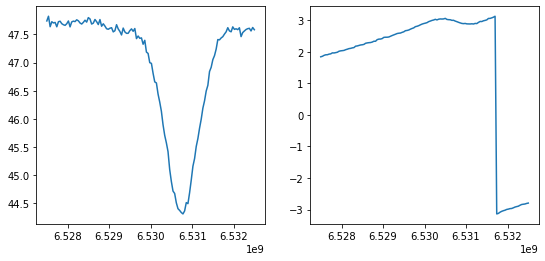

In [72]:
#await dc[q9.inst['dc']].DC(1.9)
freq,current, num, tag = np.linspace(-2.5,2.5,126)*1e6+f_lo, -0.02, n, 'xue_crossover_q10'
await psg_ex.setValue('Output','OFF')
await jpa_switch('ON')
job = Job(S21, (freq,), tags=[tag], comment="1D_%d"%num, max=len(freq))
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

# 重新混频

In [58]:
async def again(q=None):
    global f_lo, delta, n
    if q:
        f_lo, delta, n = await resn(np.array(q.f_lo))

    freq = np.linspace(-2.5,2.5,161)*1e6+f_lo
    
    await psg_ex.setValue('Output','OFF')
    job = Job(S21, (freq,),auto_save=False, tags=['test'], comment="1D_%d"%n, max=len(freq))
    f_s21, s_s21 = await job.done()
    index = np.abs(s_s21).argmin(axis=0)
    f_res = np.array([f_s21[:,i][j] for i, j in enumerate(index)])
    base = np.array([s_s21[:,i][j] for i, j in enumerate(index)])
    f_lo, delta, n = await resn(np.array(f_res))
    await psg_lo.setValue('Frequency',f_lo)
    if n != 1:
#         await ats_setup(delta)
#         await modulation_read(awg133,delta,n)
        await mr.modulation_read(ats,awg133,delta,tdelay=1500)
        await mr.ats_setup(ats,delta,l=1500)
    
        base = 0
        for i in range(50):
            ch_A, ch_B = await ats.getIQ()
#         Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
#         base += Am + 1j*Bm
            Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
            theta0 = np.angle(Am) - np.angle(Bm)
            Bm *= np.exp(1j*theta0)
            base += Am + Bm
        base /= 50
   
    return f_lo, delta, n, f_res,base

In [70]:
f_lo

6679312500.0

# S21vsFlux

In [49]:
async def S21vsFlux(q,freq,current,num):
    await psg_ex.setValue('Output','OFF')
    await psg_lo.setValue('Output','ON')
    for i in current:

#         for k,j in enumerate(q):
#             c = i*bias_cross[k] + bias_cross1[k]
#             await awg131.setValue('Offset',c,ch=j.inst['ch'])

#         await awg131.query('*OPC?')

#         await dc[q.inst['dc']].DC(i)
        
#         c0, c1, c2 = i*bias_cross[2],i*bias_cross[3],i*bias_cross[4]
#         await (globals().get(q3.inst['dc'])).DC(c0+bias_cross1[0]) 
#         await (globals().get(q4.inst['dc'])).DC(c1+bias_cross1[1]) 
#         await (globals().get(q5.inst['dc'])).DC(c2+bias_cross1[2])
#         for j in range(10):
            
#             await dc[q[j].inst['dc']].DC(i*bias_cross[j]+bias_cross1[j])
        #c0, c1, c2 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2]
#         await dc[q[0].inst['dc']].DC(c0+bias_cross1[0]) 
#         await dc[q[1].inst['dc']].DC(c1+bias_cross1[1])
#         await dc[q[2].inst['dc']].DC(c2+bias_cross1[2])
#         await dc[q[3].inst['dc']].DC(i)

        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], max=len(freq))
        f_s21, s_s21 = await job.done()
        yield [i]*num, f_s21, s_s21

In [50]:
current, num, j = np.linspace(-1,1,11), n, 0
#f_cavity = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.615,6.63])*1e9
freq = np.linspace(-2.5,2.5,51)*1e6+f_lo
bit = [q8]

for q in bit:
    #f_lo, delta, num = await res(f_cavity)
    await jpa_switch('ON')
    job = Job(S21vsFlux, (q,freq,current,num), tags=[q.q_name], max=len(current))
    volt, f_bias, s_bias = await job.done()
    #save('S21vsFlux',tag,row=volt,col=f_bias,s=s_bias,tags=tag)
    await close(inst)

Output()

In [261]:
q1 = q1._replace(inst={'dc':dc05,'dc_name':'dc05'})

In [265]:
for i, v in enumerate(bit):
    await v.inst['dc'].DC((i+1)/1000)
    time.sleep(5)

# S21vsPower

In [947]:
async def S21vsPower(freq,att,num):
    att_setup = op.Att_Setup("COM7")
    for i in att:
        att_setup.Att(i)
        await psg_pump.setValue('Output','ON')
        await psg_ex.setValue('Output','OFF')
        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], comment="1D_%d"%n, max=len(freq))
        f_s21, s_s21 = await job.done()
        #print(np.shape((c0,c1,c2)),np.shape(f),np.shape(v))
        yield [i]*num, f_s21, s_s21
    att_setup.close()

In [948]:
freq, att, num, tag = np.linspace(-3,3,61)*1e6+f_lo, np.linspace(0,30,31), n, 'xue_crossover_q4'
job = Job(S21vsPower, (freq,att,num), tags=[tag], comment="2D_%d"%num, max=len(att))
power, f_power, s_power = await job.done()

Output()

In [445]:
save('S21vsPower',tag,row=power,col=f_power,s=s_power,tags=tag,comment="2D_%d"%num)

WindowsPath('D:/QuLabData/2019/1026/S21vsPower/xue_crossover_q4_20191026205722.npz')

# Singlespec

In [30]:
async def modulation_single(awg,delta_ex,n,w):

    wf = WF(t_list)
    await awg.create_waveform(name='Ex_Q', length=len(t_list), format=None)
    await awg.create_waveform(name='Ex_I', length=len(t_list), format=None)
    f,phi,height,t_end,width = delta_ex,[0]*n,[1],[89700],[w]
    sample = wf.square_wave(t_end,width,height)
    await awg.update_waveform(sample,name='Ex_Q')
    await awg.update_marker(name='Ex_Q',mk1=sample)
    f,phi,height,t_end,width = delta_ex,[np.pi/2]*n,[1],[89700],[w]
    sample = wf.square_wave(t_end,width,height)
    await awg.update_waveform(sample,name='Ex_I')
    time.sleep(5)
await modulation_single(awg133,delta_ex,n,25000)

In [76]:
async def awg_z(awg,bias):
    
    t_range = (-90e-6, 10e-6)
    sample_rate = 2.5e9
    init = ((Step(5e-9) << 25300/1e9) - (Step(5e-9)<<100/1e9))*bias
    #init = DC(offset=-0.7, length=100e-6, range=(0,1))*0 + bias
    wav = init
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    await awg.create_waveform(name='z', length=250000, format=None)
    await awg.update_waveform(points, 'z')
    time.sleep(5)

In [113]:
await awg131.use_waveform(name='ch5',ch=5)

In [218]:
await awg133.use_waveform(name='Readout_I',ch=7)
await awg133.use_waveform(name='Readout_Q',ch=8)
await awg133.use_waveform(name='Ex_I',ch=3)
await awg133.use_waveform(name='Ex_Q',ch=4)
await awg133.use_waveform(name='z',ch=5)
for i in range(1,6):
    await awg131.use_waveform(name='test',ch=i)

In [2007]:
bias = 0
    
t_range = (-90e-6, 10e-6)
sample_rate = 2.5e9
#lo = Expi(2*np.pi*Delta_lo)
#init = CosPulseDrag(during,alpha=0.5,Delta=266e6) << 0.5*during
init = DC(offset=-0.7, length=100e-6, range=(0,1))*0 + bias
wav = init
wav.set_range(*t_range)
points = wav.generateData(sample_rate)
await awg133.update_waveform(points, 'z')
time.sleep(5)

In [59]:
async def singlespec(freq,base,num):
    await psg_ex.setValue('Output','ON')
    for i in freq:
        await psg_ex.setValue('Frequency',i)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        #theta = np.angle(s) - np.angle(base)
        #base *= np.exp(1j*theta)
        yield [i]*num, s-base

## 找读出点

In [73]:
x = sy.Symbol('x',real=True)
bias = -0.1
np.float(q3.specfunc.evalf(subs = {x:bias}))*1e9

3640847186.712816

In [74]:
q = q3
# bias = round(q.T_bias[1] - q.T_bias[0] / 32 * 7,3)
# #bias = q.bias
await dc[q4.inst['dc']].DC((q4.T_bias[0]/2+q4.T_bias[1]))
await dc[q2.inst['dc']].DC((q2.T_bias[0]/2+q2.T_bias[1]))
await dc[q.inst['dc']].DC(bias)

In [75]:
await jpa_switch('ON')
f_lo, delta, n, f_res,base = await again()

Output()

In [46]:
await psg106.setValue('Output','OFF')

## 扫谱

COM12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 60.0
now ATT 60.0


Output()

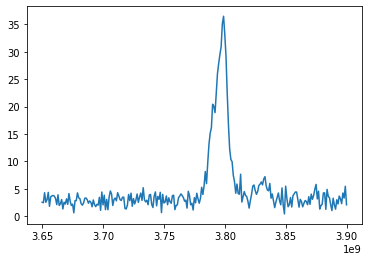

In [78]:
freq, power, num, att_single = np.arange(-100,151,1)*1e6+3.75e9, -6, n, 60

await psg_ex.setValue('Power',power)
#await ats_setup(delta=delta,repeats=1000, awg = 0)
att_setup = mr.Att_Setup("COM12")
att_setup.Att(att_single)
att_setup.close()

#await modulation_single(awg133,[80e6],n,25000)
job = Job(singlespec, (freq, base, num),tags=[q.q_name],max=len(freq))
f_ss, s_ss = await job.done()
#await close(inst)
index = np.abs(s_ss).argmax(axis=0)
f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
plt.plot(f_ss,abs(s_ss))
plt.show()

In [55]:
await psg_ex.setValue('Power',0)

In [79]:
f_rabi[0]

3799000000.0

In [137]:
q1 = q1._replace(bias=bias,f_ex=f_rabi)

In [583]:
plt.plot(f_rabi[:7],'*')
plt.hlines([3.74e9],xmin=0,xmax=7,linestyles='dashdot')
plt.show()

NameError: name 'f_rabi' is not defined

In [584]:
f_rabi

NameError: name 'f_rabi' is not defined

In [585]:
f_rabi

NameError: name 'f_rabi' is not defined

In [586]:
q1 = q1._replace(f_lo=f_lo,bias=bias,f_ex=f_rabi)

NameError: name 'bias' is not defined

In [587]:
f_rabi = 3.634e9

## 多个扫

In [588]:
freq, power, num, att_single = np.linspace(3.45,3.95,501)*1e9, 16, n, 40
await psg_ex.setValue('Power',power)
await close(inst)
await ats_setup(delta=delta,repeats=500, awg = 0)
att_setup = op.Att_Setup("COM12")
att_setup.Att(att_single)
att_setup.close()
await modulation_single(awg133,[80e6],n,25000)

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 35.0


In [589]:
q_state = []
for i,j in enumerate(bit):
    bias = round(j.T_bias[1] - j.T_bias[0] / 32 * 5,3)
    await dc[j.inst['dc']].DC(bias)
    await jpa_switch('ON')
    data_read = await again(q=j)
    job = Job(singlespec, (freq, data_read[4], data_read[2]),tags=['old_crossover_q%d'%i],max=len(freq))
    f_ss, s_ss = await job.done()
    await close(inst)
    index = np.abs(s_ss).argmax(axis=0)
    f_rabi = np.array([round(f_ss[:,i][j]) for i, j in enumerate(index)])
    if j.f_lo-data_read[0]<5e6:
        q_state.append(j._replace(bias=bias,f_lo=data_read[0],delta=data_read[1],f_ex=f_rabi,delta_ex=[0]))
plt.plot(f_ss,abs(s_ss))
plt.show()

NameError: name 'bit' is not defined

In [ ]:
f_rabi

In [ ]:
bit

In [ ]:
bit

In [ ]:
q10

In [ ]:
for i in range(len(f_ss.T)):
    x, y = f_ss[:,i], np.abs(s_ss[:,i])
    para = guess(x,y)
    res = ls(err,para,args=(x,y))
    a,b,c,d = res.x

In [ ]:
plt.plot(x,y)
plt.plot(x,1.0/(a+c*(x-b)**2)+d)
plt.show()

In [ ]:
print(f_rabi-b,b)

In [ ]:
b = f_rabi

In [ ]:
plt.plot(f_ss,abs(s_ss))
plt.show()

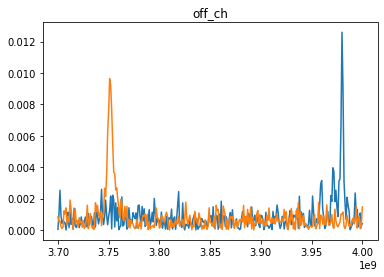

In [1489]:
plt.plot(f_ss,abs(s_ss))
plt.title('off_ch')
plt.show()

# spec_crosstalk_cali

In [22]:
def err(para,x,y):
    a,b,c,d = para
    #y0 = 1.0/(1+((x-b)/(1e-3*Gamma))**2) + Offs
    return 1.0/(a+c*(x-b)**2)+d-y
def guess(x,y):
    z = np.sort(np.abs(y))
    d = np.mean(z[:int(len(z)/2)])
    y = np.abs(y)- d
    cha = np.abs(np.abs(y)-np.abs(y).max() / 2)
    b = x[np.abs(y).argmax()]
    bw = x[cha.argmin()]-b
    if np.abs(bw) > 0.5e6:
        bw = 0.5e6
    a = 1 / np.abs(y).max()
    c = a / bw**2
    return a,b,c,d

In [23]:
async def spec_cali(q_target,q_bias,di_target,num,f_lo,delta,n):
    await jpa_switch('ON')
    await psg_lo.setValue('Output','ON')
    dc_test, t0 = 0.1, 50
    while True:
        
        await dc[q_target.inst['dc']].DC(q_target.bias)
        await dc[q_bias.inst['dc']].DC(dc_test)
        f_lo, delta, n, f_res, base = await again(q=q_target)
        freq = np.linspace(-180,180,361)*1e6+q_target.f_ex
        job = Job(singlespec, (freq, base, num),tags=['old_crossover_%s'%q_target.q_name],max=len(freq))
        f_ss, s_ss = await job.done()
        index = np.abs(s_ss).argmax(axis=0)
        f_rabi1 = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
        if np.abs(1/(f_rabi1-q_target.f_ex)) == np.inf:
            dc_test = dc_test/2
            t0 = t0/2
            continue
        else:
            break
            
    await dc[q_target.inst['dc']].DC((q_target.bias+0.002))
    await dc[q_bias.inst['dc']].DC(0)
    f_lo, delta, n, f_res, base = await again(q=q_target)
    freq = np.linspace(-80,80,161)*1e6+q_target.f_ex
    job = Job(singlespec, (freq, base, num),tags=['old_crossover_%s'%q_target.q_name],max=len(freq))
    f_ss, s_ss = await job.done()
    index = np.abs(s_ss).argmax(axis=0)
    f_rabi2 = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
    t = (f_rabi2-q_target.f_ex)/(f_rabi1-q_target.f_ex)*t0
    volt = -t*di_target
    print(t,volt)
    point = 41
    if int(np.abs(t)) < 40:
        point = 2*int(np.abs(t)) + 1
    di_bias = np.linspace(-1,1,point)*int(np.abs(t))/1000+volt

    await psg_ex.setValue('Frequency',q_target.f_ex)
    await dc[q_target.inst['dc']].DC((di_target+q_target.bias))

    for i in di_bias:
        i = round(i,3)
        await dc[q_bias.inst['dc']].DC(i)
        f_lo, delta, n, f_res, base = await again(q_target)
        await psg_lo.setValue('Frequency',f_lo)
        await psg_ex.setValue('Output','ON')
        time.sleep(0.05)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        theta = np.angle(s) - np.angle(base)
        base *= np.exp(1j*theta)
        yield [i]*n, s-base
        

In [24]:
crosstalk = np.identity(5)

6554840000.0


Output()

bad data q2


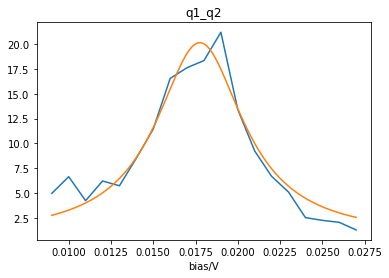

Output()

bad data q3


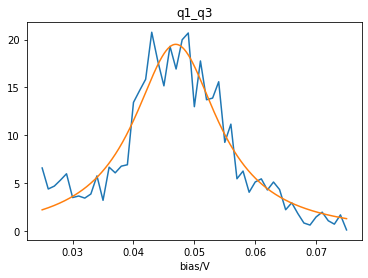

Output()

bad data q4


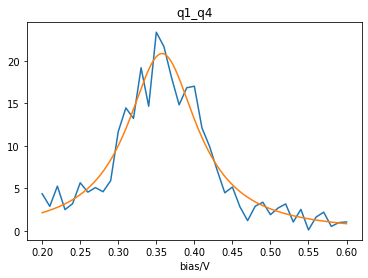

Output()

bad data q5


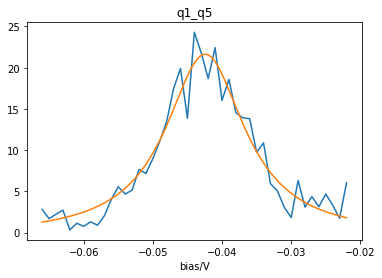

6568040000.0


Output()

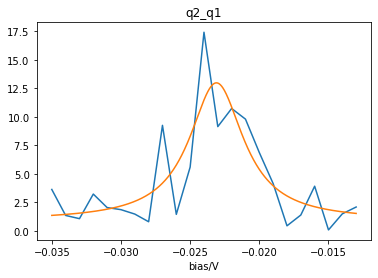

Output()

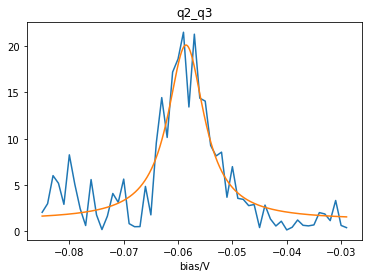

Output()

bad data q4


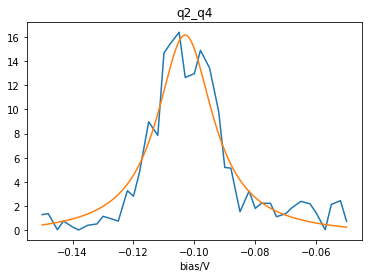

Output()

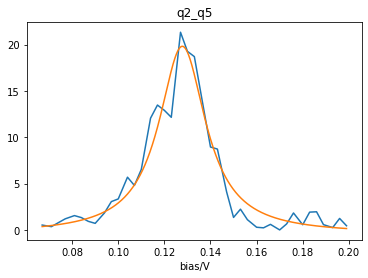

6580640000.0


Output()

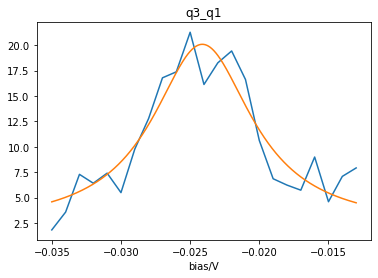

Output()

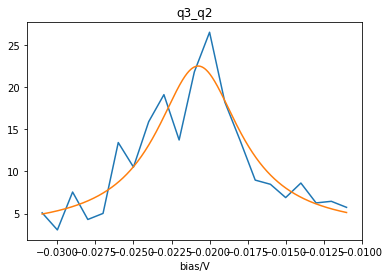

Output()

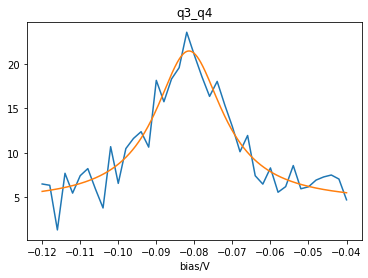

Output()

bad data q5


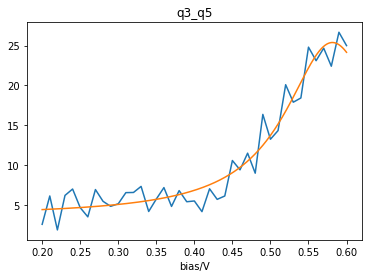

6593840000.0


Output()

bad data q1


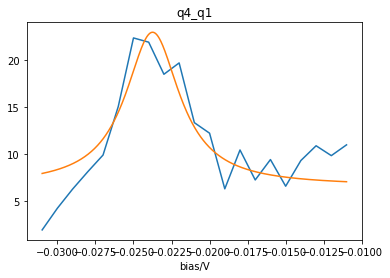

Output()

bad data q2


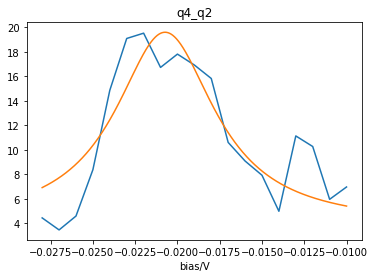

Output()

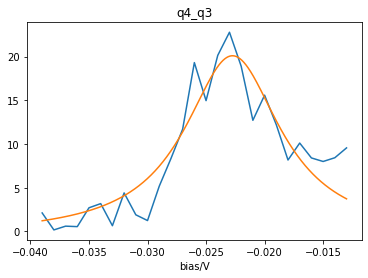

Output()

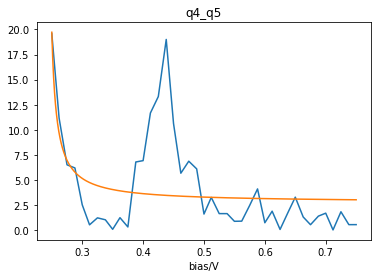

6608760000.0


Output()

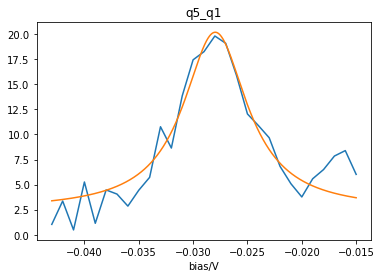

Output()

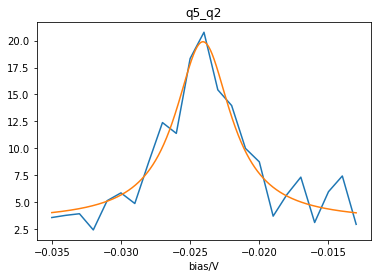

Output()

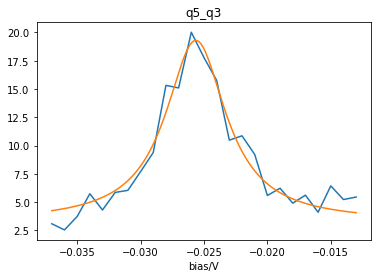

Output()

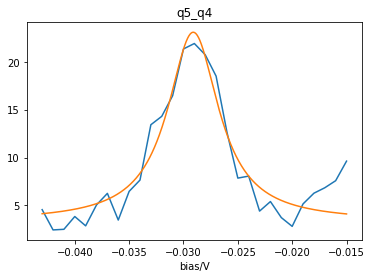

In [25]:
q_target, q_bias, di_target, num = q1, q4, 0.002, 1
bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
bit_again = [q1,q2,q3,q4,q5]
f = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.615,6.63])*1e9

for l,m in enumerate(bit_again):
    q_target = m
    n_target = bit.index(q_target)
    f_lo, delta, n = q_target.f_lo, q_target.delta, 1
    print(f_lo)
    for v,k in enumerate(bit_again):
        if k == q_target:
            continue
        job = Job(spec_cali,(q_target,k,di_target,num,f_lo, delta, n),tags=['old_crossover_%s'%q_target.q_name], max=33)
        v_sc, s_sc = await job.done()

        index = np.abs(s_sc).argmax(axis=0)
        v_bias = np.array([v_sc[:,i][j] for i, j in enumerate(index)])
        for j in range(len(v_sc.T)):
            x, y = v_sc[:,j], np.abs(s_sc[:,j])
            para = guess(x,y)
            res = ls(err,para,args=(x,y))
            a,b,c,d = res.x
        x1 = np.linspace(min(x),max(x),1001)
        y1 = 1/(a+c*(x1-b)**2)+d
        b1 = x1[y1.argmax()]
        if np.abs(b1-v_bias)>0.001:
            print('bad data %s'%k.q_name)
        crosstalk[n_target,v] = -0.002/b1
        plt.plot(x,y)
        plt.plot(x1,y1)
        plt.title(''.join((q_target.q_name,'_',k.q_name)))
        plt.xlabel('bias/V')
        plt.savefig(r'D:\QuLabData\crosstalk_cali\%s.png'%''.join((q_target.q_name,'_',k.q_name)))
        plt.pause(1)
        plt.close()
        save('crosstalk_cali',''.join((q_target.q_name,'_',k.q_name)),mat=crosstalk)
        await close(inst)

In [26]:
save('crosstalk_cali','q1-q5',mat=crosstalk)

WindowsPath('D:/QuLabData/2020/0107/crosstalk_cali/q1-q5_20200107053759.npz')

## 单个

Output()

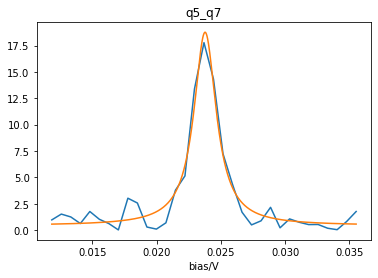

In [1182]:
q_target, q_bias, di_target, num = q5, q7, 0.002, 1

job = Job(spec_cali,(q_target,q_bias,di_target,num,f_lo, delta, n),tags=['old_crossover_%s'%q_target.q_name], max=33)
v_sc, s_sc = await job.done()

index = np.abs(s_sc).argmax(axis=0)
v_bias = np.array([v_sc[:,i][j] for i, j in enumerate(index)])
for j in range(len(v_sc.T)):
    x, y = v_sc[:,j], np.abs(s_sc[:,j])
    para = guess(x,y)
    res = ls(err,para,args=(x,y))
    a,b,c,d = res.x
x1 = np.linspace(min(x),max(x),1001)
y1 = 1/(a+c*(x1-b)**2)+d
b1 = x1[y1.argmax()]
if np.abs(b1-v_bias)>0.001:
    print('bad data %s'%q_bias.q_name)
crosstalk[4,6] = -0.002/b1
plt.plot(x,y)
plt.plot(x1,y1)
plt.title(''.join((q_target.q_name,'_',q_bias.q_name)))
plt.xlabel('bias/V')
plt.savefig(r'D:\QuLabData\crosstalk_cali\%s.png'%''.join((q_target.q_name,'_',q_bias.q_name)))
plt.pause(1)
plt.close()
save('crosstalk_cali',''.join((q_target.q_name,'_',q_bias.q_name)),mat=crosstalk)
await close(inst)

In [491]:
await psg_lo.query('Frequency?')

'6580880000\n'

In [704]:
q1

qubit(q_name='q1', inst={'dc': 'dc05'}, T_bias=[-0.27, 0.33], bias=0.2, zpulse=None, f_lo=6555000000.0, delta=50000000.0, f_ex=3769000898.599489, delta_ex=0, power_ex=None, pi_len=None, T1=None)

In [539]:
b1 = x1[y1.argmax()]
b1

-0.026556923076923075

In [1140]:
data = np.load(r'D:\QuLabData\2019\1217\crosstalk_cali\q5_q7_20191217042108.npz')
x = data['mat']
x

array([[ 1.        , -0.11869436, -0.04027927, -0.00559284,  0.04840271,
         0.08377425,  0.09487666,  0.09182736,  0.06641366,  0.04789272],
       [ 0.09398496,  1.        ,  0.03720238,  0.02150934, -0.01815102,
        -0.05641926, -0.06833996, -0.07267442, -0.05849754, -0.04654916],
       [ 0.08629442,  0.09769539,  1.        ,  0.02469136, -0.00398406,
        -0.0501002 , -0.07049345, -0.07940574, -0.07345226, -0.06204757],
       [ 0.09044411,  0.102657  ,  0.08728692,  1.        , -0.07083333,
        -0.05487523, -0.08087907, -0.09116809, -0.08680556, -0.07516189],
       [ 0.07754514,  0.08960573,  0.08475503,  0.07294786,  1.        ,
        -0.05114126, -0.0917768 , -0.0984252 ,  0.36565657, -0.08995747],
       [-0.08189717, -0.09500352,  0.91428571, -0.07763975, -0.02522704,
         1.        ,  0.10660981,  0.09995387,  0.10460251,  0.08863939],
       [-0.05370339, -0.06444406, -0.07033585, -0.06269592, -0.03926016,
        -0.00331301,  1.        ,  0.07605583

In [540]:
crosstalk[2,1] = -0.002/b1

In [27]:
crosstalk

array([[ 1.        , -0.11268875, -0.04259851, -0.00559284,  0.04710316],
       [ 0.08658758,  1.        ,  0.03418102,  0.01941748, -0.01565925],
       [ 0.08295313,  0.09643202,  1.        ,  0.02455796, -0.00343879],
       [ 0.084246  ,  0.09648784,  0.08791209,  1.        , -0.008     ],
       [ 0.07152053,  0.0831048 ,  0.07797879,  0.06870019,  1.        ]])

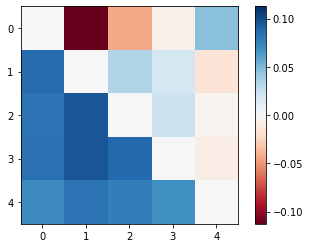

In [34]:
M = crosstalk-np.diag(np.ones(5))

plt.imshow(M, vmax=np.max(np.abs(M)), vmin=-np.max(np.abs(M)), cmap='RdBu')
plt.colorbar()

In [1220]:
save('crosstalk_cali','q1-q10_final',mat=crosstalk)

WindowsPath('D:/QuLabData/2019/1218/crosstalk_cali/q1-q10_final_20191218010637.npz')

In [556]:
save('crosstalk_cali','q3-q5',mat=crosstalk)

WindowsPath('D:/QuLabData/2019/1213/crosstalk_cali/q3-q5_20191213002118.npz')

## 优化找谱

In [ ]:
async def op_crosstalk(q_target,q_bias,volt_bias,df_target):
    await jpa_switch('ON')
    await psg_lo.setValue('Output','ON')
    
    await dc[q_bias.inst['dc']].DC(volt_bias)
    #f_lo, delta, n = await resn(np.array([q_target.f_lo-q_target.delta]))
    data_read = await again(q=q_target)
    freq = np.linspace(-180,180,361)*1e6+q_target.f_ex
    job = Job(singlespec, (freq, data_read[4], data_read[2]),tags=['old_crossover_%s'%q_target.q_name],max=len(freq))
    f_ss, s_ss = await job.done()
    index = np.abs(s_ss).argmax(axis=0)
    f_rabi1 = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
    return np.abs(f_rabi1-df_target)[0]
    
    
from qulab.math import optimize




optimize(target, [0, 0, 0, 0, 0, 0, 0, 0, 0],
         senstive=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
         dec=[3],
         print_info=True)

    
    
    
    
    

In [19]:
from qulab.math import opt
import numpy as np

help(opt.optimize)

Help on function optimize in module qulab.math.opt:

optimize(target, start, senstive=None, dec=None, high=None, low=None, print_info=False)
    target: 目标函数
    start: 起始点
    senstive: list 敏感度
    dec: list 小数位数
    high: list 上限
    low: list 下限
    print_info: bool



In [13]:
def get_initial_simplex(start, senstive=None):
    if senstive is None:
        senstive = np.ones(len(start))

    initial_simplex = [list(start)]
    for i, v in enumerate(senstive):
        row = list(start)
        row[i] += v
        initial_simplex.append(row)
    return np.asarray(initial_simplex)

In [20]:
20*np.log10(35)

30.881360887005513

## Z_crosstalk

In [29]:
t_range = (-90e-6, 10e-6)
sample_rate = 2.5e9

async def updateWaveform_z(awg,volt,pi_len,during=400e-9, shift=-200e-9, Delta_lo=80e6,name=['Ex_I','Ex_Q']):

    init = ((Step(2e-9)<<during) - Step(2e-9)) * volt
    wav = (init >> (shift-pi_len-50e-9)) 
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)

    await awg.update_waveform(I, name[0])
    #await awg.update_waveform(Q, name[1])

In [333]:
i=0.1
for k in range(5):
    c = bias_cross1[k]
    if k>1:
        c = [[0]]
    await awg131.use_waveform(name='ch%d'%(k+1),ch=k+1)
    await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=300e-9,shift=-100e-9,name=['ch%d'%(k+1)])

In [39]:

async def z_cross(t,num,len_data):
    t = t[1:len_data+1]
    t = np.array([t]*num).T
    global base
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(500):
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s

## 真空拉比扫电压

In [420]:
j = 0
await awg131.stop()
time.sleep(5)
voltage = np.linspace(-0.1,0.5,501)
for i in tqdm(voltage,desc='sequence'):
    j += 1
    bias_rabi = [0,0,0,-0.7144,i]
    bias_cross1 = np.mat(mat1).I * np.mat(bias_rabi).T 
    for k in range(5):
        c = bias_cross1[k]
        if k == 4:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=19*1e-9,shift=-100e-9,name=['z3_%d'%j])
        if k == 3:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=19*1e-9,shift=-100e-9,name=['z2_%d'%j])
        if k == 2:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=19*1e-9,shift=-100e-9,name=['z_%d'%j])
        if k == 1:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=19*1e-9,\
                                   shift=-100e-9,name=['coherence_Q%d'%j])
        if k == 0:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=19*1e-9,\
                                   shift=-100e-9,name=['coherence_I%d'%j])

## 真空拉比扫时间

matrix([[ 0.94167391],
        [-0.8129575 ],
        [ 0.87102031],
        [-0.7241186 ],
        [ 0.30304232]])

In [426]:
bias_cross1 = np.mat(mat1).I * np.mat([0.95,-0.803,0.874,-0.7144,0.2996]).T   #-0.9,-0.8,-0.8,-0.8,-0.9
j = 0
await awg131.stop()
time.sleep(5)
voltage = np.linspace(0,500,501)
for i in tqdm(voltage,desc='sequence'):
    j += 1
    for k in range(5):
        c = bias_cross1[k]
        if k == 4:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=i*1e-9,shift=-100e-9,name=['z3_%d'%j])
        if k == 3:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=i*1e-9,shift=-100e-9,name=['z2_%d'%j])
        if k == 2:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=i*1e-9,shift=-100e-9,name=['z_%d'%j])
        if k == 1:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=i*1e-9,\
                                   shift=-100e-9,name=['coherence_Q%d'%j])
        if k == 0:
            await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=i*1e-9,\
                                   shift=-100e-9,name=['coherence_I%d'%j])
            
bias_cross1

In [406]:
await awg131.use_sequence(name='coherence_131', channels=[2,1,3,4,5])

In [39]:
qubits = [q1,q2,q3,q4,q5]
z_crosstalk = np.zeros((5,5))

In [11]:
z_crosstalk = np.array([[52.05078346,  -0.31962913,  0.12344951,  0.17660073,  0.63980263],
       [ 1.11020398, 56.49076864,  -0.57352021,  -0.16710279,  -0.34449877],
        [ 0.76974233,  1.46401918, 67.24919081,  -1.12433672,  -0.48980766],
       [ 0.72579158,  1.39534747,  1.6419143 , 63.61145582,  -1.19134248],
       [ 0.56366971,  1.04181169,  0.91135554,  0.9490544 , 60.88177969]])

In [12]:
M = []
for i in range(5):
    M.append(z_crosstalk[i]/z_crosstalk[i,i])
    
M = np.asarray(M)
M

array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [59]:
M = []
for i in range(5):
    M.append(z_crosstalk[i]/z_crosstalk[i,i])
    
M = np.asarray(M)
M

array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [498]:
import pandas as pd
index = list(range(1,6))
data = pd.DataFrame(M,index=index,columns=index)
data

1         2         3         4         5
1  1.000000 -0.006141  0.002372  0.003393  0.012292
2  0.019653  1.000000 -0.010152 -0.002958 -0.006098
3  0.011446  0.021770  1.000000 -0.016719 -0.007283
4  0.011410  0.021935  0.025812  1.000000 -0.018728
5  0.009258  0.017112  0.014969  0.015588  1.000000

In [497]:
help(pd.DataFrame)

Help on class DataFrame in module pandas.core.frame:

class DataFrame(pandas.core.generic.NDFrame)
 |  DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
 |  
 |  Two-dimensional size-mutable, potentially heterogeneous tabular data
 |  structure with labeled axes (rows and columns). Arithmetic operations
 |  align on both row and column labels. Can be thought of as a dict-like
 |  container for Series objects. The primary pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, argument order is maintained for Python 3.6
 |         and later.
 |  
 |  index : Index or array-like
 |      Index to use for resulting frame. Will default to RangeIndex if
 |      no indexing information part of input data and no index provided
 |  columns : Index or arra

In [61]:
save('crosstalk_cali','q1-q5_z',mat=M)

WindowsPath('D:/QuLabData/2020/0108/crosstalk_cali/q1-q5_z_20200108113416.npz')

In [37]:
mat1

array([[ 1.        , -0.11869436, -0.04027927, -0.00559284,  0.04840271],
       [ 0.09398496,  1.        ,  0.03720238,  0.02150934, -0.01815102],
       [ 0.08629442,  0.09769539,  1.        ,  0.02469136, -0.00398406],
       [ 0.09044411,  0.102657  ,  0.08728692,  1.        , -0.00789474],
       [ 0.07754514,  0.08960573,  0.08475503,  0.07294786,  1.        ]])

In [10]:
M - np.array([[ 1.        , -0.11869436, -0.04027927, -0.00559284,  0.04840271],
       [ 0.09398496,  1.        ,  0.03720238,  0.02150934, -0.01815102],
       [ 0.08629442,  0.09769539,  1.        ,  0.02469136, -0.00398406],
       [ 0.09044411,  0.102657  ,  0.08728692,  1.        , -0.00789474],
       [ 0.07754514,  0.08960573,  0.08475503,  0.07294786,  1.        ]])

NameError: name 'M' is not defined

In [47]:
save('crosstalk_cali','q1-q5',mat=z_crosstalk)

WindowsPath('D:/QuLabData/2020/0108/crosstalk_cali/q1-q5_20200108094554.npz')

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.5


Output()

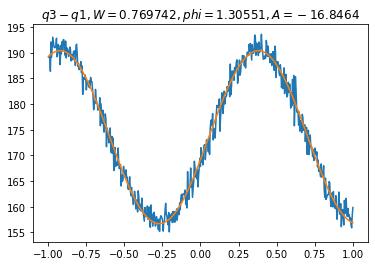

Output()

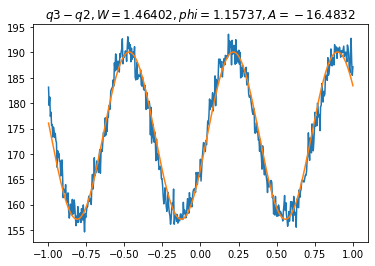

Output()

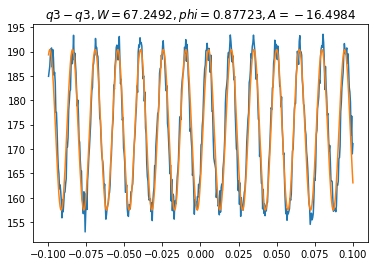

Output()

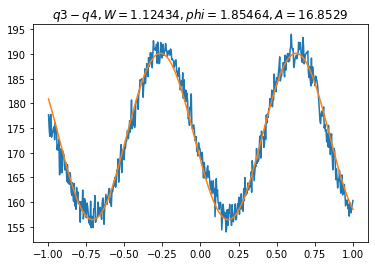

Output()

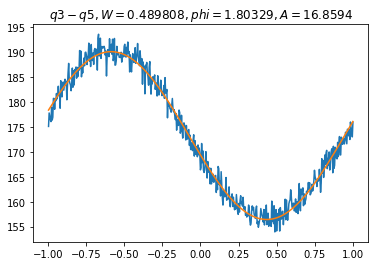

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.5


Output()

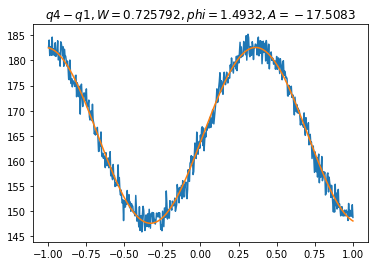

Output()

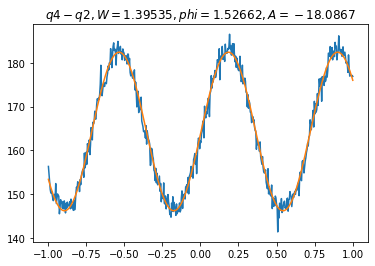

Output()

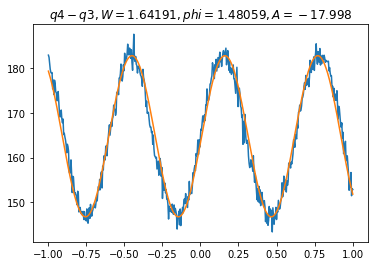

Output()

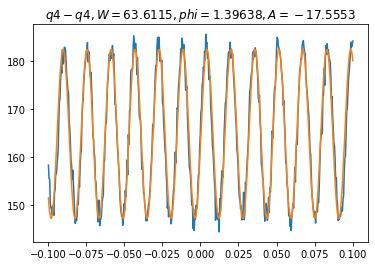

Output()

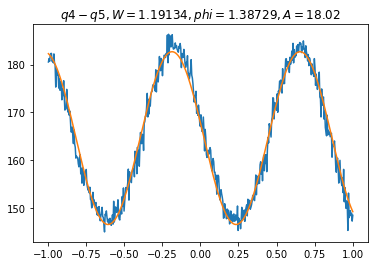

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 16.5


Output()

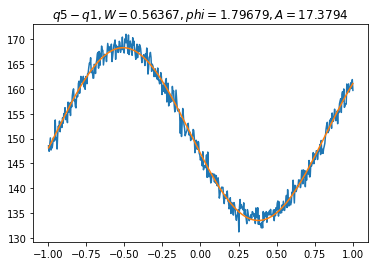

Output()

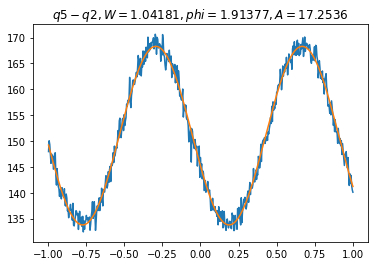

Output()

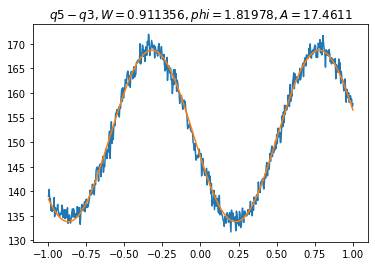

Output()

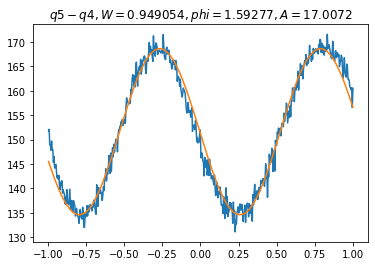

Output()

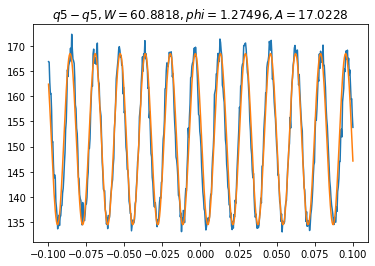

In [56]:
for v,k in enumerate(qubits[2:],start=2):
    q_target = k
    await ats_setup(delta, repeats=500, awg = 1)
    await jpa_switch('ON')
    await psg_lo.setValue('Frequency',q_target.f_lo)
    await psg_ex.setValue('Frequency',q_target.f_ex+q_target.delta_ex+0.5e6)
    await dc[q_target.inst['dc']].DC(q_target.bias)
    att_setup = op.Att_Setup("COM12")
    att_setup.Att(q_target.power_ex)
    att_setup.close()
    for i,j in enumerate(qubits):
        q_bias = j
        if q_bias == q_target:
            voltage = np.linspace(-0.1,0.1,501)
            await awg131.use_sequence(name='coherence_131', channels=[i+1,i+1,i+1,i+1])
        else:
            voltage = np.linspace(-1,1,501)
            await awg131.use_sequence(name='coherence_131', channels=[i+1,i+1,i+1])
        await awg131.run()
        await awg133.run()
        await ats_setup(delta, repeats=500, awg = 1)
        time.sleep(15)
        job = Job(z_cross,(voltage,1,data_len),tags=['old_crossover_q4'], max=500, avg=True)
        v_z, s_z = await job.done()
        await awg131.use_waveform(name='test',ch=i+1)
        try:
            A, C, W, phi = op.Cos_Fit().fit_cos(v_z[:,0], s_z[:,0])
        except Exception or RuntimeWarning:
            A, C, W, phi =0,0,0,0
        z_crosstalk[v,i] = W
        plt.plot(v_z,abs(s_z))
        plt.plot(v_z,A*np.cos(2*np.pi*W*v_z+phi)+C)
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await close(inst)


In [57]:
z_crosstalk

array([[ 0.7686403 ,  1.44656372,  0.12344951,  0.17660073,  0.63980263],
       [ 1.11020398, 56.49076864,  0.57352021,  0.16710279,  0.34449877],
       [ 0.76974233,  1.46401918, 67.24919081,  1.12433672,  0.48980766],
       [ 0.72579158,  1.39534747,  1.6419143 , 63.61145582,  1.19134248],
       [ 0.56366971,  1.04181169,  0.91135554,  0.9490544 , 60.88177969]])

In [108]:
save('z_cross',tag,row=v_z,col=s_z,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2020/0107/z_cross/old_crossover_q4_20200107190650.npz')

# Rabi

In [80]:
t_list = np.linspace(0,100000,250000)

In [81]:
async def wave(awg,name_seq,choice=None,using=None):
    t, j = np.linspace(0,500,501), 0
    len_s = len(t)
    await awg.create_sequence(name_seq,len_s,5)
    for i in tqdm(t,desc='sequence'):
        j += 1
        if choice == 'remove':
            await awg.remove_waveform(name=''.join(('coherence_I','%d'%j)))
            await awg.remove_waveform(name=''.join(('coherence_Q','%d'%j)))
        else:
            
            if using == 'read':
                await awg.set_seq(wave_name='Readout_Q',step=j,track=2,seq_name=name_seq,
                              wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
                await awg.set_seq(wave_name='Readout_I',step=j,track=1,seq_name=name_seq,
                              wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
                await awg.set_seq(wave_name='z',step=j,track=3,seq_name=name_seq,
                              wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
            else:
                await awg.create_waveform(name=''.join(('coherence_I','%d'%j)), length=len(t_list), format=None) 
                await awg.set_seq(wave_name=''.join(('coherence_I','%d'%j)),step=j,track=2,seq_name=name_seq,
                                wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
        
                await awg.create_waveform(name=''.join(('coherence_Q','%d'%j)), length=len(t_list), format=None)      
                await awg.set_seq(wave_name=''.join(('coherence_Q','%d'%j)),step=j,track=1,seq_name=name_seq,
                                wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')
                
                await awg.create_waveform(name=''.join(('z3_','%d'%j)), length=len(t_list), format=None)      
                await awg.set_seq(wave_name=''.join(('z3_','%d'%j)),step=j,track=5,seq_name=name_seq,
                                wait='ATR',goto='NEXT',repeat='1',jump0='OFF',jump1='NEXT')

In [82]:
await wave(awg=awg133,name_seq='coherence_133')

QuLabRPCServerError: ('TypeError', "set_seq() got an unexpected keyword argument 'jump0'", 'd:\\qulab\\qulab\\rpc.py in handle_request(self, source, msgID, method)\n  279     async def handle_request(self, source, msgID, method, *args, **kw):\n  280         """\n  281         Handle a request from source.\n  282         """\n  283         try:\n  284             func = self.getRequestHandler(method, source=source, msgID=msgID)\n  285             if \'timeout\' in kw and not acceptArg(func, \'timeout\'):\n  286                 del kw[\'timeout\']\n  287             if inspect.iscoroutinefunction(func):\n  288                 result = await func(*args, **kw)\n  289             else:\n  290                 result = await self.loop.run_in_executor(\n->291                     self.executor, functools.partial(func, *args, **kw))\n  292             if isinstance(result, Awaitable):\n  293                 result = await result\n  294         except QuLabRPCError as e:\n  295             result = e\n  296         except Exception as e:\n  297             result = QuLabRPCServerError.make(e)\n  298         msg = pack(result)\n  299         await self.response(source, msgID, msg)\n  300 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\futures.py in __await__(self)\n  257     def __await__(self):\n  258         if not self.done():\n  259             self._asyncio_future_blocking = True\n->260             yield self  # This tells Task to wait for completion.\n  261         if not self.done():\n  262             raise RuntimeError("await wasn\'t used with future")\n  263         return self.result()  # May raise too.\n  264 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\tasks.py in __wakeup(self, future)\n  316     def __wakeup(self, future):\n  317         try:\n->318             future.result()\n  319         except Exception as exc:\n  320             # This may also be a cancellation.\n  321             self.__step(exc)\n  322         else:\n  323             # Don\'t pass the value of `future.result()` explicitly,\n  324             # as `Future.__iter__` and `Future.__await__` don\'t need it.\n  325             # If we call `_step(value, None)` instead of `_step()`,\n  326             # Python eval loop would use `.send(value)` method call,\n  327             # instead of `__next__()`, which is slower for futures\n  328             # that return non-generator iterators from their `__iter__`.\n  329             self.__step()\n  330         self = None  # Needed to break cycles when an exception occurs.\n  331 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\futures.py in result(self)\n  165     def result(self):\n  166         """Return the result this future represents.\n  167 \n  168         If the future has been cancelled, raises CancelledError.  If the\n  169         future\'s result isn\'t yet available, raises InvalidStateError.  If\n  170         the future is done and has an exception set, this exception is raised.\n  171         """\n  172         if self._state == _CANCELLED:\n  173             raise CancelledError\n  174         if self._state != _FINISHED:\n  175             raise InvalidStateError(\'Result is not ready.\')\n  176         self.__log_traceback = False\n  177         if self._exception is not None:\n->178             raise self._exception\n  179         return self._result\n  180 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\concurrent\\futures\\thread.py in run(self)\n   52     def run(self):\n   53         if not self.future.set_running_or_notify_cancel():\n   54             return\n   55 \n   56         try:\n-> 57             result = self.fn(*self.args, **self.kwargs)\n   58         except BaseException as exc:\n   59             self.future.set_exception(exc)\n   60             # Break a reference cycle with the exception \'exc\'\n   61             self = None\n   62         else:\n   63             self.future.set_result(result)\n   64 ')

In [141]:
await awg132.remove_sequence('common_vert')

In [217]:
await updateWaveform_rabi(awg=awg133,during=64e-9, shift=-200e-9, Delta_lo=80e6)

In [83]:
t_range = (-90e-6, 10e-6)
sample_rate = 2.5e9


async def updateWaveform_rabi(awg,during=75e-9, shift=-200e-9, Delta_lo=80e6,name=['Ex_I','Ex_Q']):

    lo = Expi(2*np.pi*Delta_lo)
    #init = CosPulseDrag(during,alpha=0.5,Delta=266e6) << 0.5*during
    init = (Step(2e-9)<<during) - Step(2e-9)
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    init1 = (Step(0e-9)<<during) - Step(0e-9)
    wav1 = (init1 >> shift) 
    wav1.set_range(*t_range)
    points1 = wav1.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)

    await awg.update_waveform(I, name[0])
    await awg.update_waveform(Q, name[1])
    await awg.update_marker(name[1],mk1=points1)


In [84]:
#delta = 50e6
async def rabi(t,num,len_data):
    t = t[1:len_data+1]
    t = np.array([t]*num).T
    global base
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(500):

        ch_A, ch_B = await ats.getIQ(hilbert=True)
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s 

In [90]:
t_rabi = np.linspace(0,100,501)
j = 0
await awg133.stop()
time.sleep(5)

for i in tqdm(t_rabi,desc='sequence'):
    j += 1
    name_ch = [''.join(('awg133coherence_I','%d'%j)),''.join(('awg133coherence_Q','%d'%j))]
    await updateWaveform_rabi(awg133,during=i/1e9, name = name_ch)

In [133]:
#f_qubit,power,t,num,att_rabi, data_len = f_rabi, 18, np.linspace(0,100,501),n,35, 500
await awg133.use_sequence(name='coherence', channels=[4, 3])
await awg133.use_sequence(name='common_vert', channels=[7,8,5])
# for i in range(1,6):
#     await awg131.use_sequence('coherence_131', channels=[i,i,i,i,i,i])

In [95]:
q_target = q3
await jpa_switch('ON')
#await psg_lo.setValue('Frequency',f_lo)
await psg_ex.setValue('Frequency',f_rabi+80e6)
att_rabi = 23
#await dc[q_target.inst['dc']].DC(q_target.bias)

In [194]:
for i,j in enu

qubit(q_name='q1', inst={'dc': 'dc05', 'awg': 'awg131', 'ch': 1}, T_bias=[2.058, 0.305], specfunc=-79.7340929883872*cos(0.0798622338469705*pi*x + 3.07549884534463) - 75.8026278492758, bias=0, zpulse=None, f_lo=6554840000.0, delta=array([50000000.]), f_ex=array([3.757e+09]), delta_ex=array([80000000.]), power_ex=15, pi_len=65, T1=None)

COM12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 10.0
now ATT 10.0


Output()

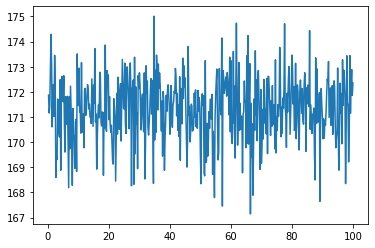

In [96]:
att_rabi = 10
#await awg131.run()
await awg133.run()
await ats_setup(delta, repeats=500, awg = 1)
att_setup = mr.Att_Setup("COM12")
att_setup.Att(att_rabi)
#time.sleep(15)
job = Job(rabi,(t_rabi,num,500),tags=[q_target.q_name], max=500, avg=True)
t_r, s_r = await job.done()
#await close(inst)
index = np.abs(s_r).argmax(axis=0)
t_pi = np.array([t_r[:,i][j] for i, j in enumerate(index)])
plt.plot(t_r,abs(s_r))
plt.show()

In [17]:
for i,j in enumerate(tqdm(range(10),desc='test')):
    time.sleep(1)
    print(i,j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9



In [256]:
for i in range(1,503):
    await awg131.write('SLIS:SEQ:STEP%d:TASS%d:WAV "%s","%s"' %(i, 6, 'coherence_131', 'test'))

In [1036]:
index = np.abs(s_r[:250]).argmax(axis=0)
t_pi = np.array([t_r[:,i][j] for i, j in enumerate(index)])

In [181]:
q5 = q5._replace(power_ex=att_rabi,pi_len=t_pi,delta_ex=np.array([80e6]))

In [133]:
q2

qubit(q_name='q2', inst={'dc': 'dc01', 'awg': 'awg131', 'ch': 2}, T_bias=[1.767, 0.005], bias=-0.271, zpulse=None, f_lo=6568040000.0, delta=array([50000000.]), f_ex=array([3.685e+09]), delta_ex=array([80000000.]), power_ex=10, pi_len=64, T1=None)

In [215]:
t_pi 

array([64.])

In [216]:
t_pi = 64

In [843]:
save('Rabi',tag,row=t_r,col=s_r,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1125/Rabi/old_crossover_q4_20191125115819.npz')

# rabi with classify

In [1378]:
async def modulation_ex(delta_ex,n,w,i):

    wf = WF(t_list)
    f,phi,height,t_end,width = [delta_ex]*i,[[0]]*i,[[1]]*i,[[89900-j*(w)] for j in range(i)],[[w]]*i
    sample = wf.sin_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Ex_Q')
    f,phi,height,t_end,width = [delta_ex]*i,[[np.pi/2]]*i,[[1]]*i,[[89900-j*(w)] for j in range(i)],[[w]]*i
    sample = wf.sin_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Ex_I')
    time.sleep(4)

In [95]:
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho

t_range = (-90e-6, 10e-6)
sample_rate = 2.5e9


async def updateWaveform_rabi(during=75e-9, shift=-100e-9, Delta_lo=80e6):

    lo = Expi(2*np.pi*Delta_lo)
    #init = CosPulseDrag(during,alpha=0.5,Delta=266e6) << 0.5*during
    init = (Step(2e-9)<<during) - Step(2e-9)
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)

    await awg.update_waveform(I, 'Ex_I')
    await awg.update_waveform(Q, 'Ex_Q')



In [92]:
await updateWaveform_rabi(during=27/1e9, shift=-100e-9, Delta_lo=80e6)

In [1691]:
def boundary(x,y,k,x0,y0):
    if y-y0-k*(x-x0)>0:
        return 1
    elif y-y0-k*(x-x0)<0:
        return 0
    else:
        return 'online'


In [97]:
async def rabi(t,num,pi_num):
    wf = WF(t_list)
    global base, k, x0, y0, test
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in t:
        await updateWaveform_rabi(during=i/1e9, shift=-100e-9, Delta_lo=80e6)
        time.sleep(4)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_1 = ch_A + ch_B
        #test.append(s_on_1)
        l = len(s_on_1)
        p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
        lenth = len(p01) - p01.count('online')
        pop_z = p01.count(1) / lenth
        yield [i]*num, [pop_z]*num

In [45]:
await awg.use_waveform('Ex_I',ch=3)
await awg.use_waveform('Ex_Q',ch=4)
await awg.use_waveform('Readout_I',ch=7)
await awg.use_waveform('Readout_Q',ch=8)

Output()

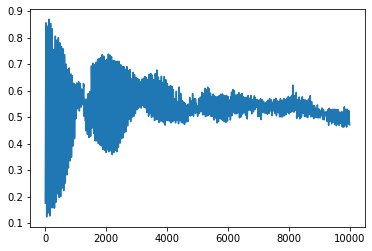

In [98]:
f_qubit,power,t,num,pi_num = f_rabi, 0, np.linspace(5,10005,2001),n,1

# await psg_ex.setValue('Power',power)
# await psg_ex.setValue('Frequency',f_qubit+80e6)
# await psg_lo.setValue('Frequency',f_lo)
job = Job(rabi,(t,num,pi_num),tags=['old_crossover_q8'],comment="1D_%d"%num,max=len(t))
t_r, s_r = await job.done()
#await close(inst)
index = np.abs(s_r).argmax(axis=0)
t_pi = np.array([t_r[:,i][j] for i, j in enumerate(index)])
plt.plot(t_r,abs(s_r))
plt.show()

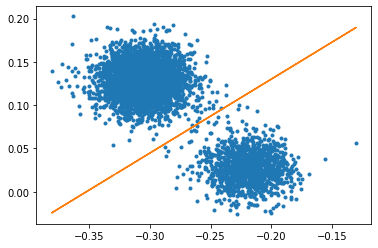

In [1377]:
fig = plt.figure()
s_on_1 = test[2]
ax = fig.add_subplot(111)
#ax.plot(np.real(s_on_0),np.imag(s_on_0),'.')
ax.plot(np.real(s_on_1),np.imag(s_on_1),'.')
ax.plot(np.real(s_on_1),line(np.real(s_on_1),k,x0,y0))
# ax.set_ylim([-0.25,0.25])
#ax.axis('equal')
plt.show()

In [1046]:
t_pi

array([80.])

# 功率Rabi

In [411]:
async def Rabi_P(p_ex,pi_len,num):
    '''
    wf = WF(t_list)
    sample_rabi = wf.square_wave(t_end=[89900],width=[pi_len],height=[1])
    #await awg.update_waveform(sample_rabi,name='Rabi')
    await awg.update_marker(name='Readout_Q',mk1=sample_rabi)
    time.sleep(5)
    '''
    att_setup = op.Att_Setup("COM7")
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')

    for i in p_ex:
        #await psg_ex.setValue('Power',i)
        att_setup.Att(i)
        #await awg.setValue('Vpp',i,ch=3)
        #await awg.setValue('Vpp',i,ch=4)
        ch_A, ch_B = await ats.getIQ()
        s = ch_A.mean(axis=0) + 1j*ch_B.mean(axis=0)
        yield [i]*num, s
    att_setup.close()

Output()

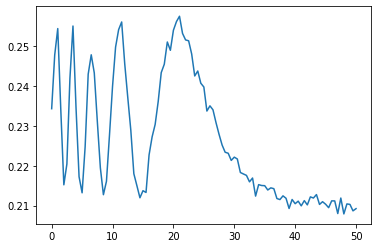

In [438]:
f_qubit,bias,power,pi_len,num = f_rabi+50e6, -0.02, np.linspace(0,50,101),t_pi,n
#await dc15.DC(bias)
await psg_ex.setValue('Frequency',f_qubit)
await psg_lo.setValue('Frequency',f_lo)
job = Job(Rabi_P,(power,pi_len,num),tags=['old_crossover_q8'],comment="1D_%d"%num,max=len(power))
p_rp, s_rp = await job.done()
p_pi = p_rp[abs(s_rp).argmax()]
plt.plot(p_rp,abs(s_rp))
plt.show()

In [439]:
save('Rabi_P',tag,row=p_rp,col=s_rp,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1026/Rabi_P/N=11_20191026202955.npz')

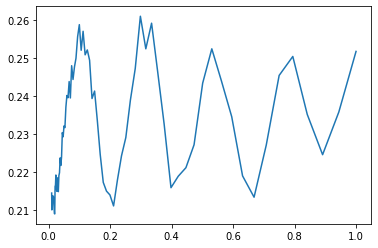

In [413]:
plt.plot(10**(-p_rp/20),abs(s_rp))
plt.show()

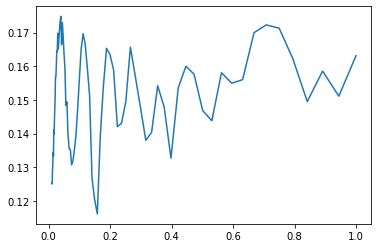

In [204]:
plt.plot(10**(-p_rp/20),abs(s_rp))
plt.show()

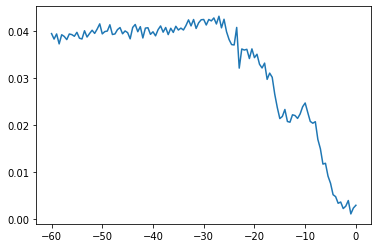

In [96]:
plt.plot(-p_rp,abs(s_rp))
plt.show()

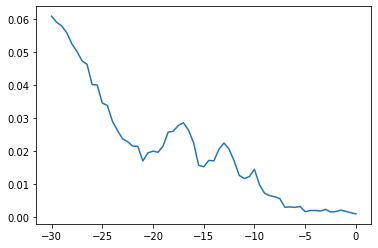

In [28]:
plt.plot(-p_rp,abs(s_rp))
plt.show()

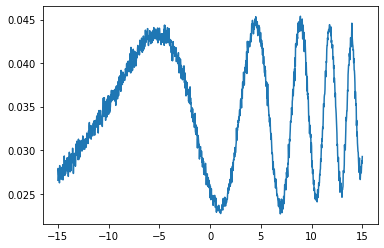

In [223]:
plt.plot(p_rp,abs(s_rp))
plt.show()

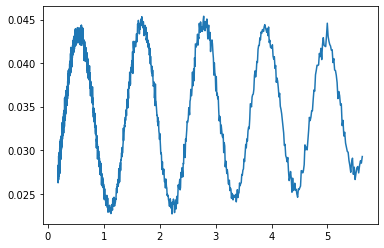

In [219]:
plt.plot(10**(p_rp/20),abs(s_rp))
plt.show()

# 读出优化

## 读出功率信噪比

In [309]:
async def Readout_P(att,num):
    att_setup = op.Att_Setup("COM3")
    for i in att:
        att_setup.Att(i)
        await psg_pump.setValue('Output','ON')
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        s_on_0 = ch_A + 1j*ch_B
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        s_on_1 = ch_A + 1j*ch_B
        r0 ,r1 = np.mean(s_on_0) ,np.mean(s_on_1)
        sigma = np.abs(np.std(s_on_0))
        SNR = np.abs(r0-r1)**2/2/sigma**2
        yield [i]*num, [SNR]*num
    att_setup.close()

Output()

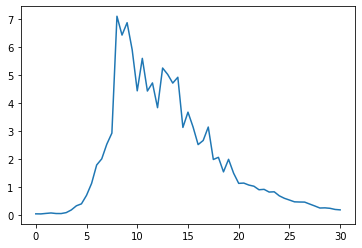

In [310]:
f_qubit,bias,att,pi_len,num = f_rabi+80e6, -0.02, np.linspace(0,30,61),t_pi,n
#await dc15.DC(bias)
#await psg_ex.setValue('Frequency',f_qubit)
await psg_lo.setValue('Frequency',f_lo)
job = Job(Readout_P,(att,num),tags=['old_crossover_q1'],comment="1D_%d"%num,max=len(att))
att_p, SNR = await job.done()
index = np.abs(SNR).argmax(axis=0)
att_op = np.array([att_p[:,i][j] for i, j in enumerate(index)]
plt.plot(att_p,abs(SNR))
plt.show()

In [312]:
index = np.abs(SNR).argmax(axis=0)
att_op = np.array([att_p[:,i][j] for i, j in enumerate(index)])
att_op

array([8.])

In [454]:
save('Readout_P',tag,row=att_p,col=SNR,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1026/Readout_P/xue_crossover_q4_20191026210707.npz')

## 读出功率fidelity

In [1857]:
async def rotate_op(s_0,s_1):

    l = len(s_0)        
    def center_f(s_0,s_1):
        l0, l1 = np.abs(s_0-np.mean(s_0)), np.abs(s_1-np.mean(s_1))
        weight0, weight1 = 1/np.std(l0)/np.sqrt(2*np.pi)*np.exp(-l0**2/np.std(l0)**2/2), 1/np.std(l1)/np.sqrt(2*np.pi)*np.exp(-l1**2/np.std(l1)**2/2)
        #weight0, weight1 = (1/l0)/np.max(1/l0), (1/l1)/np.max(1/l1)
        #weight0, weight1 = np.ones(l), np.ones(l)
        sm0, sm1 = np.average(s_0, weights=weight0), np.average(s_1, weights=weight1)
        center = (sm0 + sm1) / 2
        x0, y0 = np.real(center), np.imag(center)
        r = sm0 - sm1
        k = -np.real(r) / np.imag(r)
        return center, x0, y0, r, k, sm0, sm1

    center, x0, y0, r, k, sm0, sm1 = center_f(s_0,s_1)
        
    l = len(s_on_1)
    p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
    lenth = len(p01) - p01.count('online')
    pop_z = p01.count(1) / lenth
    
    return pop_z

In [328]:
async def Readout_fidelity(att,num):
    att_setup = op.Att_Setup("COM3")
    for i in att:
        att_setup.Att(i)
        await psg_pump.setValue('Output','ON')
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        s_on_0 = ch_A + 1j*ch_B
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        s_on_1 = ch_A + 1j*ch_B
        p = await rotate(s_on_0,s_on_1)
        yield [i]*num, [p]*num
    att_setup.close()

Output()

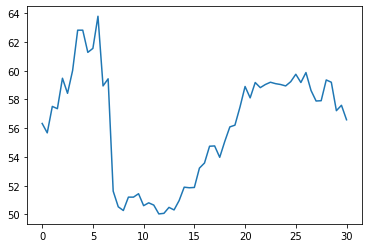

In [329]:
f_qubit,bias,att,pi_len,num = f_rabi+80e6, -0.02, np.linspace(0,30,61),t_pi,n
#await dc15.DC(bias)
#await psg_ex.setValue('Frequency',f_qubit)
await psg_lo.setValue('Frequency',f_lo)
job = Job(Readout_fidelity,(att,num),tags=['old_crossover_q1'],comment="1D_%d"%num,max=len(att))
att_fidelity, P = await job.done()
index = np.abs(P).argmax(axis=0)
att_op = np.array([att_fidelity[:,i][j] for i, j in enumerate(index)]
plt.plot(att_fidelity,abs(P))
plt.show()

In [153]:
save('Readout_fidelity',tag,row=att_fidelity,col=P,s=None,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1021/Readout_fidelity/xue_crossover_q1_20191021224252.npz')

## 读出频率信噪比

In [95]:
async def Readout_F(freq,num):
    await psg_pump.setValue('Output','ON')
    for i in freq:
        await psg_lo.setValue('Frequency',i)
        
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_0 = ch_A + ch_B
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_1 = ch_A + ch_B
        r0 ,r1 = np.mean(s_on_0) ,np.mean(s_on_1)
        sigma = np.abs(np.std(s_on_0))
        SNR = np.abs(r0-r1)**2/2/sigma**2
        yield [i]*num, [SNR]*num

Output()

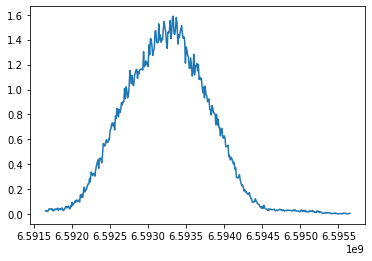

In [96]:
%matplotlib inline
freq,current, num, tag = np.linspace(-2,2,401)*1e6+f_lo, -0.02, n, 'xue_crossover_q1'
await psg_lo.setValue('Output','ON')
await psg_ex.setValue('Output','OFF')
job = Job(Readout_F, (freq,num), tags=[tag], comment="1D_%d"%num, max=len(freq))
f_rr, SNR_rr = await job.done()
index = np.abs(SNR_rr).argmax(axis=0)
f_op = np.array([f_rr[:,i][j] for i, j in enumerate(index)])
plt.plot(f_rr,abs(SNR_rr))
plt.show()

In [164]:
save('Readout_F',tag,row=f_rr,col=SNR_rr,s=None,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1021/Readout_F/xue_crossover_q1_20191021230824.npz')

In [97]:
f_op

array([6.59333e+09])

In [99]:
f_lo = 6.59333e9
await psg_lo.setValue('Frequency',f_lo)

## 优化pi_pulse

In [745]:
async def updateWaveform_op(during=75e-9, shift=-100e-9, Delta=80e6):
    
    t_range = (-90e-6, 10e-6)
    sample_rate = 2.5e9
    
    lo = Expi(2*np.pi*Delta)
    init = CosPulse(during) << 0.5*during
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)
    
    await awg.update_waveform(I, 'Ex_I')
    await awg.update_waveform(Q, 'Ex_Q')


In [746]:
await updateWaveform_op(during=58e-9, shift=-100e-9, Delta=80e6)

In [1265]:
await awg.stop()
await awg.use_waveform('ex_I_Z',ch=3)
await awg.use_waveform('ex_Q_Z',ch=4)
await awg.use_waveform('Read_I',ch=7)
await awg.use_waveform('Read_Q',ch=8)
time.sleep(1)
await awg.run()

In [1858]:
async def Pipulse_fidelity(pi_len,num):
    await psg_pump.setValue('Output','ON')
    for i in pi_len:
        await updateWaveform_op(during=i*1e-9)
        time.sleep(4)
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_0 = ch_A + ch_B
#         s_on_0 = ch_A + 1j*ch_B
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_1 = ch_A + ch_B
        p = await rotate_op(s_on_0,s_on_1)
        yield [i]*num, [p]*num

Output()

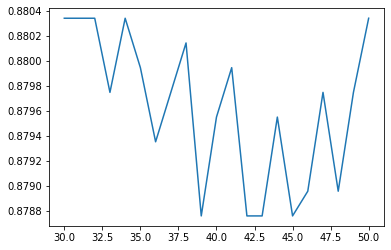

In [1862]:
pi_len, num, tag = np.linspace(-10,10,21)+40, n, 'xue_crossover_q1'
#await dc15.setValue('Offset',current)
await psg_lo.setValue('Output','ON')
job = Job(Pipulse_fidelity, (pi_len,num), tags=[tag], comment="1D_%d"%num, max=len(pi_len))
pi_len_o, P = await job.done()
index = np.abs(P).argmax(axis=0)
pi_op = np.array([pi_len_o[:,i][j] for i, j in enumerate(index)])
plt.plot(pi_len_o,np.abs(P))
plt.show()

In [1864]:
pi_op

array([30.])

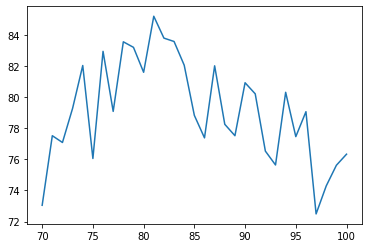

In [1027]:
plt.plot(pi_len_o,abs(P))
plt.show()

## 优化qubit频率

In [1846]:
async def Pipulse_fidelity(freq,num):
    await psg_pump.setValue('Output','ON')
    
    for i in freq:
        await psg_ex.setValue('Frequency',i)
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_0 = ch_A + ch_B
#         s_on_0 = ch_A + 1j*ch_B
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        ch_B *= np.exp(1j*theta0)
        s_on_1 = ch_A + ch_B
        p = await rotate_op(s_on_0,s_on_1)
        yield [i]*num, [p]*num

Output()

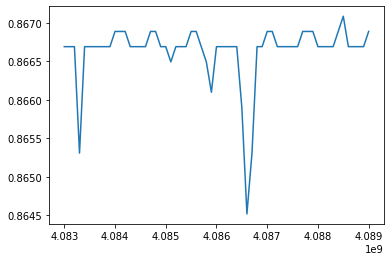

In [1847]:
freq_len, num, tag = np.linspace(-3,3,61)*1e6+f_rabi+80e6, n, 'xue_crossover_q1'
#await dc15.setValue('Offset',current)
await psg_lo.setValue('Output','ON')
job = Job(Pipulse_fidelity, (freq_len,num), tags=[tag], comment="1D_%d"%num, max=len(freq_len))
freq_len_o, P = await job.done()
index = np.abs(P).argmax(axis=0)
freq_op = np.array([freq_len_o[:,i][j] for i, j in enumerate(index)])
plt.plot(freq_len_o,np.abs(P))
plt.show()

In [1848]:
freq_op

array([4.0885e+09])

# T1

In [343]:
def fit(x, A, B, T1):
    return A * np.exp(-x/T1) + B

def guessParams(x,y):
    eps = 0.00001
    y = y-y.min()
    mask = y > eps*y.max()
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return [y.max()-y.min(), y.min(), -1/a[0]]

def analyze(x,s):
    y = np.abs(s)
    p0 = guessParams(x,y)
    popt,pcov = curve_fit(fit, x, y, p0)
    return popt, pcov


In [344]:
async def T1(pi_len,t,base,len_data):
    t = t[1:len_data+1]
    t = np.array([t]*len(base)).T
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(800):

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s

In [21]:
4

100000

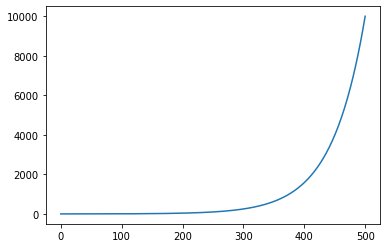

In [22]:
x = np.logspace(0,4,501,endpoint=True)
plt.figure()
plt.plot(x)
plt.show()

In [19]:
help(np.logspace)

Help on function logspace in module numpy:

logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
    Return numbers spaced evenly on a log scale.
    
    In linear space, the sequence starts at ``base ** start``
    (`base` to the power of `start`) and ends with ``base ** stop``
    (see `endpoint` below).
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    Parameters
    ----------
    start : array_like
        ``base ** start`` is the starting value of the sequence.
    stop : array_like
        ``base ** stop`` is the final value of the sequence, unless `endpoint`
        is False.  In that case, ``num + 1`` values are spaced over the
        interval in log-space, of which all but the last (a sequence of
        length `num`) are returned.
    num : integer, optional
        Number of samples to generate.  Default is 50.
    endpoint : boolean, optional
        If true, `stop` is the last sample. Otherwise, 

In [467]:
f_qubit, pi_len, t,num, tag, len_data = f_rabi, t_pi, np.linspace(0,500,501), n, 'old_crossover_q4', 500
await awg133.stop()
time.sleep(5)
j = 0
for i in tqdm(t,desc='sequence'):
    j += 1
    name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
    await updateWaveform_rabi(awg133,during=pi_len*1e-9, shift=-(i+300)*1e-9, name = name_ch)

In [340]:
await updateWaveform_rabi(awg133,during=pi_len*1e-9, shift=-(10+200)*1e-9)

In [1652]:
t_addr, z_T1 = [], []
for i in range(1):
    await awg133.run()
    time.sleep(15)
    t1 = time.time()
    t_addr.append(t1)
    job = Job(T1,(pi_len,t,base,len_data),tags=[tag],avg=True,max=800)
    t_T, s_T = await job.done()
    try:
        xdata,ydata = t_T[:,0], s_T[:,0]
        popt, pcov = analyze(abs(xdata),abs(ydata))
        A, B, T1_time = popt
        z_T1.append(T1_time)
    except RuntimeError or TypeError:
        pass

Output()

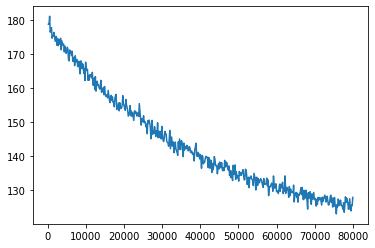

In [1653]:
plt.plot(abs(t_T), abs(s_T))
plt.show()

In [ ]:
save('T1',tag,row=np.array(t_addr),col=np.array(z_T1),s=1,tags=tag,comment="1D_%d"%num)

In [1655]:
z_T1[-1]

40862.02500990033

In [ ]:
plt.plot((np.array(t_addr)-np.min(t_addr))/60,z_T1,'ro')
plt.plot((np.array(t_addr)-np.min(t_addr))/60,z_T1,'-')
plt.xlabel('time/min')
plt.ylabel('T1')
plt.show()

In [85]:
await psg_pump.setValue('Output','OFF')
await psg_lo.setValue('Output','OFF')
await psg_ex.setValue('Output','OFF')
await awg.stop()
await dc02.DC(0)
await dc03.DC(0)
await dc04.DC(0)
await dc08.DC(0)

In [171]:
save('T1',tag,row=t_T,col=s_T,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1119/T1/old_crossover_q2_20191119000755.npz')

# Ramsey

In [183]:
async def updateWaveform_ramsey(awg,t_run,during=75e-9, shift=-200e-9, Delta_lo=80e6,name=['Ex_I','Ex_Q']):

    lo1 = Expi(2*np.pi*Delta_lo,0*np.pi*1e6*t_run)
    lo2 = Expi(2*np.pi*Delta_lo)
    init1 = ((Step(2e-9)<<0.5*during) - Step(2e-9))*lo1
    init2 = (((Step(2e-9)<<0.5*during) - Step(2e-9)) << (t_run+0.5*during))*lo2
    init = init1 + init2
    wav = (init >> shift) 
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)

    await awg.update_waveform(I, name[0])
    await awg.update_waveform(Q, name[1])

In [74]:
async def Ramsey(pi_len,base,t,len_data):
    t = t[1:len_data+1]
    t = np.array([t]*len(base)).T
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(800):

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s

In [184]:
t_pi = 65

In [185]:
f_qubit, pi_len, t, num, tag, len_data = f_rabi+80e6, t_pi, np.linspace(0,8000,501), n, 'old_crossover_q4', 500
j = 0
await awg133.stop()
time.sleep(5)

for i in tqdm(t,desc='sequence'):
    j += 1
    name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
    await updateWaveform_ramsey(awg133,t_run=500/1e9,during=pi_len/1e9, name = name_ch)

Output()

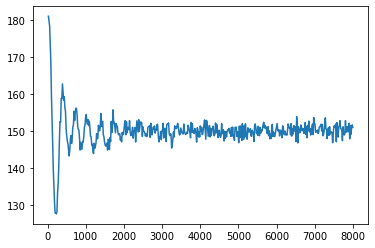

In [1661]:
await awg133.run()
await ats_setup(delta, repeats=500, awg = 1)
time.sleep(15)
job = Job(Ramsey,(pi_len,base,t,len_data),tags=[tag],max=800,avg=True)
t_R, s_R = await job.done()
plt.plot(t_R,abs(s_R))
plt.show()

In [1569]:
save('Ramsey',tag,row=t_R,col=s_R,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1219/Ramsey/old_crossover_q4_20191219091733.npz')

# SpinEcho

In [13]:
async def updateWaveform_spinecho(awg,t_run,during=75e-9,n_wave=1,kind='CPMG' ,shift=-100e-9, Delta_lo=80e6,name=['Ex_I','Ex_Q']):
    
    lo1 = Expi(2*np.pi*Delta_lo,6*np.pi*1e6*t_run)
    lo2 = Expi(2*np.pi*Delta_lo)
    lo3 = Expi(2*np.pi*Delta_lo,np.pi/2)
    #init = CosPulseDrag(during,alpha=0.5,Delta=266e6) << 0.5*during
    init1 = ((Step(2e-9)<<0.5*during) - Step(2e-9))*lo1
    init2 = (((Step(2e-9)<<0.5*during) - Step(2e-9)) << (t_run+(n_wave+0.5)*during))*lo2
    if kind == 'CPMG':
        init3, step = 0, t_run / n_wave
        for i in range(n_wave):
            init3 += (((Step(2e-9)<<during) - Step(2e-9)) << ((i+0.5)*step+(i+0.5)*during))*lo3
    else:
        init3, step = 0, t_run / (n_wave + 1)
        for i in range(n_wave):
            init3 += (((Step(2e-9)<<during) - Step(2e-9)) << ((i+1)*step+(i+0.5)*during))*lo3
            
    init = init1 + init2 + init3
    wav = (init >> shift) 
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    
    I, Q = np.real(points), np.imag(points)
    return I,Q

#     await awg.update_waveform(I, name[0])
#     await awg.update_waveform(Q, name[1])

In [5]:
t_range = (-90e-6, 10e-6)
sample_rate = 2.5e9

<IPython.core.display.Javascript object>


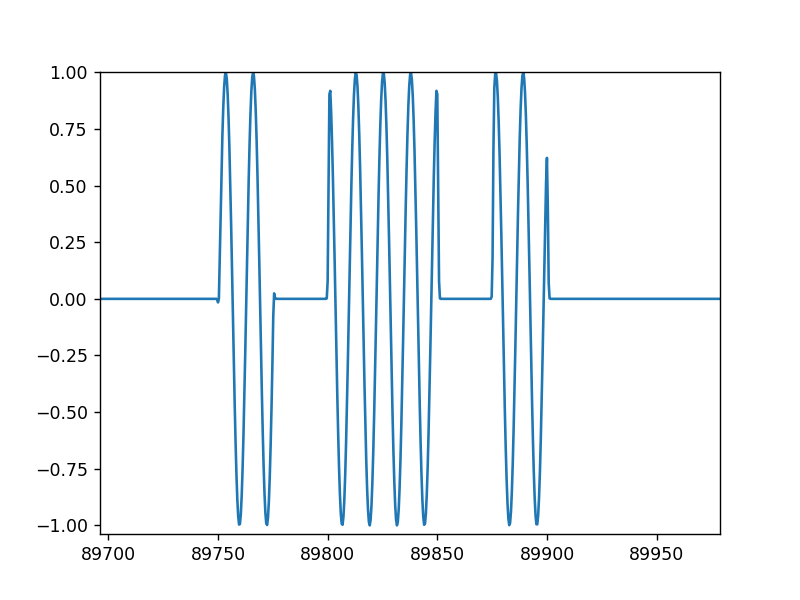

In [19]:
%matplotlib notebook
t = np.linspace(0,100000,250000)
I, Q= await updateWaveform_spinecho(awg=0,t_run=50e-9,during=50e-9)
plt.plot(t,Q)
plt.show()

In [8]:
224750-224363

387

In [1663]:
await updateWaveform_spinecho(awg133,t_run=100e-9,during=100e-9,n_wave=10)

In [1825]:
async def SpinEcho(pi_len,t,base,len_data):
    t = t[1:len_data+1]
    t = np.array([t]*len(base)).T
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(800):

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s

In [1665]:
f_qubit, bias, power, pi_len, t, num, tag = f_rabi+5e6, 0.06, -3, t_pi, np.linspace(0,10000,501), n, 'old_crossover_q2'
j = 0
await awg133.stop()
time.sleep(5)
for i in tqdm(t,desc='sequence'):
    j += 1
    name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
    await updateWaveform_spinecho(awg133,t_run=i*1e-9,during=pi_len*1e-9,n_wave=1,name=name_ch)

Output()

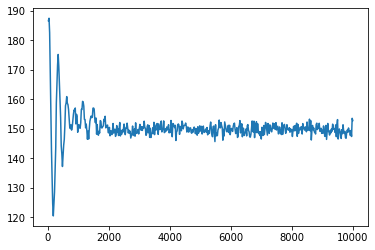

In [1666]:
await awg133.run()
time.sleep(15)
job = Job(SpinEcho,(pi_len,t,base,len_data),tags=[tag],comment="1D_%d"%num,max=800,avg=True)
t_S, s_S = await job.done()
plt.plot(t_S,abs(s_S))
plt.show()

In [1575]:
save('SpinEcho',tag,row=t_S,col=s_S,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1219/SpinEcho/old_crossover_q2_20191219092524.npz')

In [896]:
await close(inst)
await awg.stop()

NameError: name 'awg' is not defined

# CPMG and PDD

In [1588]:
pi_len, t, num, n_wave = t_pi, np.linspace(0,40000,501), n, 2
async def update_CPMG(n_wave):
    j = 0
    await awg.stop()
    time.sleep(5)
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_spinecho(awg133,t_run=i*1e-9,during=pi_len*1e-9,n_wave=n_wave,name=name_ch)

In [1577]:
async def CPMG(pi_len,t,base):
    
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in t:

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        theta = np.angle(s) - np.angle(base)
        base *= np.exp(1j*theta)
        yield [i]*n, s-base

In [1592]:
for i in range(3):
    n_wave = i+1
    await update_CPMG(n_wave)
    await awg.run()
    time.sleep(15)
    tag = 'xue_crossover_q4_%s'%n_wave
    job = Job(CPMG,(pi_len,t,base),tags=[tag],comment="1D_%d"%num,max=len(t),avg=True)
    t_C, s_C = await job.done()


Output()

Output()

Output()

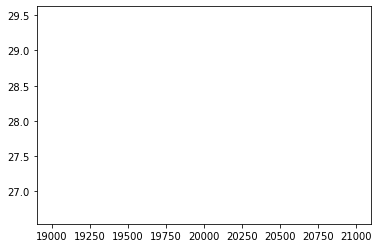

In [1593]:
plt.plot(t_C,abs(s_C))
plt.show()

In [1595]:
s_C

array([22.31533488-17.04815893j])

In [1591]:
save('CPMG',tag,row=t_C,col=s_C,s=1,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2019/1219/CPMG/xue_crossover_q4_20_20191219140824.npz')

# zpulse扫普

In [1699]:
mat2 = mat[1:3,1:3]
bias_cross2 = np.mat(mat2).I * np.mat([1,0]).T

In [1701]:
async def Z_2spec(freq,current,power,pi_len,tag):
    
    global f_lo, delta, n 
    wf = WF(t_list)
    await psg_ex.setValue('Power',power) 
    f_lo, delta, n, f_res, base = await again() 
    await psg_lo.setValue('Frequency',f_lo)
    f,phi,height,t_end,width = delta_ex,[0]*n,[1],[89700],[pi_len]
    sample = wf.square_wave(t_end,width,height)
    await awg.update_marker(name='Ex_I',mk1=sample)
    '''
    await awg.update_waveform(sample,name='Ex_Q')
    f,phi,height,t_end,width = delta_ex,[np.pi/2]*n,[1],[89700],[pi_len]
    sample = wf.square_wave(t_end,width,height)
    await awg.update_waveform(sample,name='Ex_I')   
    '''
    for i in current:   
        c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross2[0],i*bias_cross2[1],i*bias_cross[3]
        #sample_z = wf.square_wave(t_end=[89900],width=[800],height=[float(c0)])         
        #await awg.update_waveform(sample_z,name='z0_1')  
        sample_z = wf.square_wave(t_end=[89900],width=[800],height=[float(c1)])         
        await awg.update_waveform(sample_z,name='z1_1') 
        sample_z = wf.square_wave(t_end=[89900],width=[800],height=[float(c2)])         
        await awg.update_waveform(sample_z,name='z2_1')  
        #sample_z = wf.square_wave(t_end=[89900],width=[800],height=[float(c3)])         
        #await awg.update_waveform(sample_z,name='z3_1')
        #await awg.update_marker(name='trigger_zsk',mk1=sample_z) 

        time.sleep(6)       
        await psg_ex.setValue('Output','ON')         
        job = Job(singlespec, (freq, base, n),auto_save=False,tags=[tag],comment="1D_%d"%num,max=len(freq))         
        f_ss, s_ss = await job.done()         
        #print(np.shape((c0,c1,c2)),np.shape(f),np.shape(v))         
        yield [i]*n, f_ss, s_ss

In [1702]:
#f_cavity = np.array([6.470])*1e9  
#f_lo, delta, n = await res(f_cavity) 
freq, current, power, pi_len, num, tag = np.linspace(3.5,4.1,601)*1e9, np.linspace(-0.7,0,71),-5,t_pi, n, 'xue_crossover_q4567' 
job = Job(Z_2spec,(freq,current,power,pi_len,tag),tags=[tag],comment="2D_%d"%num, max=len(current)) 
v_s2, f_s2, s_s2 = await job.done() 
save('Z_2spec',tag,row=v_s2,col=f_s2,s=s_s2,tags=tag,comment="2D_%d"%num) 
await close(inst)

Output()

# 2spec

In [614]:
async def spec2d(freq,current,bias_cross,power,tag):
    global f_lo, delta, n
    await jpa_switch('ON')
    #await psg_ex.setValue('Power',power)
    for i in current:
        
        await updateWaveform_z(awg=awg131,volt=i,pi_len=-50e-9,during=5200e-9,shift=-100e-9,name=['ch%d'%3])
#         for k in range(5):
#             c = i*bias_cross[k] 
#             await updateWaveform_z(awg=awg131,volt=np.array(c)[0,0],pi_len=-50e-9,during=5200e-9,shift=-100e-9,name=['ch%d'%(k+1)])
        time.sleep(6)
        f_lo, delta, n, f_res, base = await again()
        await psg_lo.setValue('Frequency',f_lo)
        await psg_ex.setValue('Output','ON')
        job = Job(singlespec, (freq, base, n),auto_save=False,tags=[tag],comment="1D_%d"%n,max=len(freq))
        f_ss, s_ss = await job.done()
        yield [i]*n, f_ss, s_ss

In [619]:
for k in range(5):
     await awg131.use_waveform(name='test',ch=k+1)

In [615]:
#f_cavity = np.array([6.470])*1e9  
#f_lo, delta, n = await res(f_cavity) 
freq, current, power, num, tag = np.linspace(3.4,4.1,701)*1e9, np.linspace(-1,1,51),10, n, 'xue_crossover_q12345'
await psg_ex.setValue('Power',power)
job = Job(spec2d,(freq,current,bias_cross,power,tag),tags=[tag],comment="2D_%d"%num, max=len(current)) 
v_s2, f_s2, s_s2 = await job.done() 
save('spec2d',tag,row=v_s2,col=f_s2,s=s_s2,tags=tag,comment="2D_%d"%num) 
#await close(inst)

Output()

WindowsPath('D:/QuLabData/2020/0114/spec2d/xue_crossover_q12345_20200114004551.npz')

In [27]:
t_pi = 72

In [184]:
for i in range(5):
    volt_z = [0,0,0,0,0]
    volt_z[i] = 1
    bias_cross = np.mat(mat1).I * np.mat(volt_z).T
    freq, current, power, pi_len, num, tag = np.linspace(3.4,4.1,701)*1e9, np.linspace(-1,1,41),15,t_pi, n, 'xue_crossover_q12345' 
    job = Job(spec2d,(freq,current,bias_cross,power,tag),tags=[tag],comment="2D_%d"%num, max=len(current)) 
    v_s2, f_s2, s_s2 = await job.done() 
    save('spec2d',tag,row=v_s2,col=f_s2,s=s_s2,tags=tag,comment="2D_%d"%num) 
#await close(inst)

Output()

Output()

Output()

Output()

Output()

In [616]:
await awg131.stop()

## spec2d_awg

In [233]:
async def spec2d_awg(freq,current,tag,k,awg):
    global f_lo, delta, n

    await awg_z(awg,0)
    await awg.output_on(ch=globals()['q%d'%(k)].inst['ch'])
    f_lo, delta, n, f_res, base = await again()
    await psg_lo.setValue('Frequency',f_lo)
    await psg_ex.setValue('Output','ON')
    
    for i in current:
        await awg_z(awg,i)
        job = Job(singlespec, (freq, base, n),auto_save=True,tags=[tag],comment="1D_%d"%10,max=len(freq))
        f_ss, s_ss = await job.done()
        yield [i]*n, f_ss, s_ss
    

In [109]:
current_points = np.array([0.19,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])
current = np.linspace(-1,1,41)
freq, power = np.linspace(3.65,4.05,401)*1e9, 10
await jpa_switch('ON')
bias_cross = np.mat(mat1).I * np.mat(current_points).T   

for j in range(10):
    print('q%d'%(j+1),bias_cross[j])
    await dc[globals()['q%d'%(j+1)].inst['dc']].DC(bias_cross[j])
    
for k in range(1,11,1):
    tag = 'working_point_q%d'%(k)
    
    job = Job(spec2d_awg,(freq,current,tag,k,awg_list[globals()['q%d'%(k)].inst['awg']]),tags=[tag], max=len(current))
    v_s2, f_s2, s_s2 = await job.done()
    save('spec2d_awg',tag,row=v_s2,col=f_s2,s=s_s2,tags=tag)
    await awg.output_off(ch=globals()['q%d'%(k)].inst['ch'])
await close(inst)
    

q1 [[0.14051177]]
q2 [[0.16625438]]
q3 [[-0.16675666]]
q4 [[0.78654913]]
q5 [[0.10520401]]
q6 [[0.08649123]]
q7 [[-0.08580955]]
q8 [[0.07462403]]
q9 [[0.07623546]]
q10 [[1.06053111]]


In [374]:
awg = awg134
await awg.use_waveform(name='z',ch=6)
awg_z(awg,0)

<coroutine object awg_z at 0x0000023D46481548>

## 10bits 2spec

In [69]:
async def spec2d(freq,current,power,tag,k,current_point):
#     global f_lo, delta, n
#     await psg_ex.setValue('Power',power)
#     if k == 9:
#         l = k-1
#     if k !=9:
#         l=k
#     f_lo, delta, n = await resn(np.array([globals()['q%d'%(l+1)].f_lo-50e6,globals()['q%d'%(l+2)].f_lo-50e6]))
#     await ats_setup(delta)
#     await modulation_read(awg133,delta,n)
    for l,i in enumerate(current):
        current_point[k] = i
        #print(current_point)
        bias_cross = np.mat(mat1).I * np.mat(current_point).T   
        for j in range(10):
            #print('q%d'%(j+1),bias_cross[j])
            await dc[globals()['q%d'%(j+1)].inst['dc']].DC(bias_cross[j])
        print('%d:%f'%(l,i),end=',')
        time.sleep(5)
#         f_lo, delta, n, f_res, base = await again()
#         await psg_lo.setValue('Frequency',f_lo)
#         await psg_ex.setValue('Output','ON')
#         job = Job(singlespec, (freq, base, n),auto_save=False,tags=[tag],comment="1D_%d"%num,max=len(freq))
#         f_ss, s_ss = await job.done()
#         yield [i]*n, f_ss, s_ss
        yield 1,1,1

In [70]:
current_points = np.array([0.19,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])
bias10 = np.linspace(-0.2,0.2,41)
freq, power = np.linspace(3.7,4.0,301)*1e9, 10
await jpa_switch('ON')
for k,j in enumerate(current_points[7:8]):
    current = bias10+j
    current_point = np.array([0.19,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])
    tag = 'working_point_q%d'%(k+1)
    job = Job(spec2d,(freq,current,power,tag,7,current_point),auto_save=False, tags=[tag], max=len(current))
    v_s2, f_s2, s_s2 = await job.done()
    #save('spec2d',tag,row=v_s2,col=f_s2,s=s_s2,tags=tag)

await close(inst)
    

Output()

In [65]:
current_point = np.array([0.19,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])

In [73]:
current_point[7] = 0.018
#print(current_point)
bias_cross = np.mat(mat1).I * np.mat(current_point).T   
for j in range(10):
    #print('q%d'%(j+1),bias_cross[j])
    await dc[globals()['q%d'%(j+1)].inst['dc']].DC(bias_cross[j])

In [56]:
bias_cross = np.mat(mat1).I * np.mat(np.array([-0.03,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])).T
bias_cross

matrix([[-0.0744811 ],
        [ 0.18377906],
        [-0.15229598],
        [ 0.80066255],
        [ 0.11566392],
        [ 0.07610587],
        [-0.09550602],
        [ 0.06625982],
        [ 0.07051805],
        [ 1.0639937 ]])

In [55]:
bias_cross = np.mat(mat1).I * np.mat(np.array([-0.02,0.13,-0.195,0.71,0.07,0.11,-0.03,0.118,0.133,1.13])).T
bias_cross

matrix([[-0.0647087 ],
        [ 0.18298249],
        [-0.15295329],
        [ 0.80002104],
        [ 0.11518847],
        [ 0.07657793],
        [-0.09506527],
        [ 0.06664001],
        [ 0.07077794],
        [ 1.0638363 ]])

## 多个扫

In [112]:
async def spec2d(freq,qubit):
    #f_lo, delta, n = qubit.f_lo, qubit.delta, 1
    current = np.linspace(-qubit.T_bias[0]*0.3,qubit.T_bias[0]*0.3,31) + qubit.T_bias[1] 
    await jpa_switch('ON')
    
    for i in current:
        await dc[qubit.inst['dc']].DC(i)
        f_lo, delta, n, f_res, base = await again()
        await psg_ex.setValue('Output','ON')
        job = Job(singlespec, (freq, base, n),auto_save=False,max=len(freq))
        f_ss, s_ss = await job.done()
        yield [i]*n, f_ss, s_ss

In [113]:
freq, bit = np.linspace(3.45,4.15,701)*1e9, [q8]
for i,j in enumerate(bit):
    tag = j.q_name
    job = Job(spec2d,(freq,j),auto_save=True, tags=[tag], max=31)
    v_s2, f_s2, s_s2 = await job.done()

    await close(inst)
    

Output()

In [22]:
q2

qubit(q_name='q2', inst={'dc': 'dc01', 'awg': 'awg131', 'ch': 2}, T_bias=[1.972, 0.562], specfunc=0.1*cos(x), bias=-0.271, zpulse=None, f_lo=[6518000000.0], delta=array([50000000.]), f_ex=array([3.685e+09]), delta_ex=array([80000000.]), power_ex=6, pi_len=array([69.4]), T1=None)

# 真空拉比

In [26]:
t_list = np.linspace(0,20000,50000)
t_pi=410
f_rabi = 4.41e9

In [27]:
bias = 1
c0, c1 = bias*bias_cross[0],bias*bias_cross[1]
await dc11.DC(c0) 
await dc15.DC(c1)

In [28]:
async def Rabi2(freq,pi_len,t,h,num,tag):
    wf = WF(t_list)     
    await psg_lo.setValue('Output','ON')     
    await psg_ex.setValue('Output','ON')     
    for i in t:         
        sample_z = wf.square_wave(t_end=[89900],width=[i],height=[float(h[0])])        
        await awg.update_waveform(sample_z,name='z')  
        sample_z1 = wf.square_wave(t_end=[89900],width=[i],height=[float(h[1])])       
        await awg.update_waveform(sample_z1,name='z1')
        sample_z2 = wf.square_wave(t_end=[89900],width=[i],height=[float(h[2])])       
        await awg.update_waveform(sample_z2,name='z2')
        sample_pi = wf.square_wave(t_end=[89700-i],width=[pi_len],height=[1])
        await awg.update_marker(name='trigger_zsk',mk1=sample_pi)         
        time.sleep(6)  
        job = Job(singlespec, (freq, base, num),auto_save=False,tags=[tag],comment="1D_%d"%num,max=len(freq))
        f_ss, s_ss = await job.done()        
        yield [i]*num, f_ss, s_ss

In [ ]:
bias_cross_z = np.mat(mat).I * np.mat([0,-0.95,0]).T
bias_cross_z

In [30]:
bias_cross_z = np.mat(mat).I * np.mat([0,-0.95,0]).T
freq, h, power, num, t, pi_len, tag = np.linspace(-100,100,201)*1e6+f_rabi, bias_cross_z, -5, n, np.linspace(0,100,201),t_pi, 'xue_crossover_q8910'
await psg_ex.setValue('Power',power)
await psg_lo.setValue('Frequency',f_lo)
job = Job(Rabi2,(freq,pi_len,t,h,num,tag),tags=[tag],comment="2D_%d"%num, max=len(t))
t_r2, f_r2, s_r2 = await job.done()
save('Rabi2',tag,row=t_r2,col=f_r2,s=s_r2,tags=tag,comment="2D_%d"%num)
await close(inst)

Output()

## 扫时间和电压

In [765]:
async def update(w):
    wf = WF(t_list)
    volt = np.linspace(-0.4,0,41)
    j = 0
    for i in volt:
        j += 1
        name0,name1,name2,name3,name4 = ''.join(('z_','%d'%j)),''.join(('z2_','%d'%j)),''.join(('z3_','%d'%j)),\
        ''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))
            
        c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3]
            
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c0)],[89800],[w]
        #sample0 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample0,name=name0)
        
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c1)],[89800],[w]
        #sample1 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample1,name=name1)
        
        f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[i],[89850],[w]
        sample2 = wf.square_wave(t_end,width,height)
        await awg.update_waveform(sample2,name=name2)
        
        #f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c3)],[89800],[w]
        #sample3 = wf.square_wave(t_end,width,height)
        #await awg.update_waveform(sample3,name=name3) 
        #await awg.query('*OPC?')

In [362]:
async def single(volt,w,num,data_len=500):
    t = volt
    t = t[1:len_data+1]
    t = np.array([t]*len(base)).T
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(800):

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s

In [718]:
async def wave(width):
    j =  0
    wf = WF(t_list)
    for i in t:
        j += 1
        name_w, name_s, track = ''.join(('z0_','%d'%j)), 'Bias', 1
        
        c0, c1, c2,c3 = i*bias_cross[0],i*bias_cross[1],i*bias_cross[2],i*bias_cross[3]
        f,phi,height,t_end,width = [delta_ex],[[np.pi/2]],[float(c0)],[89900],[width]
        sample = wf.square_wave(t_end,width,height)
    

In [363]:
async def Rabi3(volt,pi_len,t,num,tag):
    wf = WF(t_list)     
    await psg_lo.setValue('Output','ON')     
    await psg_ex.setValue('Output','ON')     
    for i in t:
        
#         f,phi,height,t_end,width = [delta_ex],[[0]*n],[[1]],[[89700-i]],[[pi_len]]
#         sample = wf.sin_envelope(f,phi,t_end,width,height)
#         #await awg.update_marker(name='Ex_I',mk1=sample)
#         await awg.update_waveform(sample,name='Ex_Q')
#         f,phi,height,t_end,width = [delta_ex],[[np.pi/2]*n],[[1]],[[89700-i]],[[pi_len]]
#         sample = wf.sin_envelope(f,phi,t_end,width,height)
#         await awg.update_waveform(sample,name='Ex_I')
        job = Job(single,(volt,i,num),tags=[tag],auto_save=False,comment="2D_%d"%num,avg=True, max=len(volt))
        v_s, s_s = await job.done()     
        yield [i]*num,v_s,s_s

In [364]:
volt, power, num, t, pi_len, tag = [-0.5], 15, n, np.linspace(0,150,501),t_pi, 'xue_crossover_q6789'
#await psg_ex.setValue('Power',power)
# await psg_lo.setValue('Frequency',f_lo)
# await psg_ex.setValue('Frequency',f_rabi+80e6)
await ats_setup(delta, repeats=500, awg = 1)
job = Job(Rabi3,(volt,pi_len,t,num,tag),tags=[tag],comment="2D_%d"%num,avg=True, max=len(t))
t_r3, f_r3, s_r3 = await job.done()
save('Rabi3',tag,row=t_r3,col=f_r3,s=s_r3,tags=tag,comment="2D_%d"%num)
#await close(inst)

Output()

IndexError: index 0 is out of bounds for axis 0 with size 0

## single

In [208]:
for i in range(1,6):
    await awg131.output_on(ch=i)

In [494]:
async def single(t,data_len=500):
    t = t[1:len_data+1]
    t = np.array([t]*len(base)).T
    await psg_lo.setValue('Output','ON')
    await psg_ex.setValue('Output','ON')
    for i in range(1000):

        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A[1:len_data+1,:],ch_B[1:len_data+1,:]
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield t, s - base

Output()

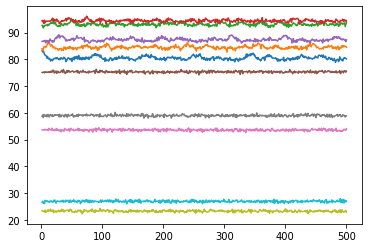

In [495]:
await awg131.use_sequence(name='coherence_131', channels=[2,1,3,4,5])
await awg133.run()
await awg131.run()
await psg_ex.setValue('Frequency',f_rabi+80e6)
await psg_ex.setValue('Power',16)
await ats_setup(delta, repeats=500, awg = 1)
time.sleep(20)
job = Job(single,(voltage,500),tags=[tag],max=1000,avg=True,auto_save=True)
t_T, s_T = await job.done()
job.data.save()
plt.plot(t_T,abs(s_T))
plt.show()

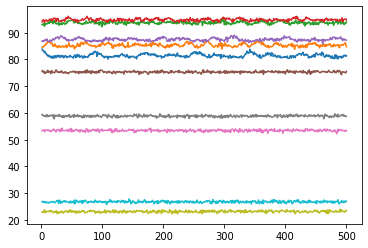

In [491]:
t_T = np.asarray(t_T)
s_T = np.asarray(s_T)

plt.plot(t_T.mean(axis=0),abs(s_T.mean(axis=0)))
plt.show()

In [484]:
s_T.shape

(1000, 500, 10)

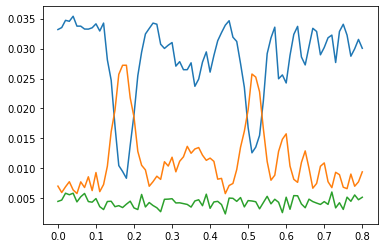

In [741]:
plt.plot(f_r3,abs(s_r3))
plt.show()

In [742]:
index = np.abs(s_r3).argmax(axis=0)
v_op = np.array([f_r3[:,i][j] for i, j in enumerate(index)])
v_op

array([0.04, 0.18, 0.72])

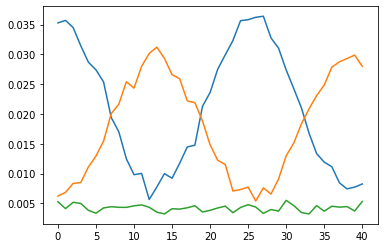

In [760]:
plt.plot(t_r3,abs(s_r3))
plt.show()

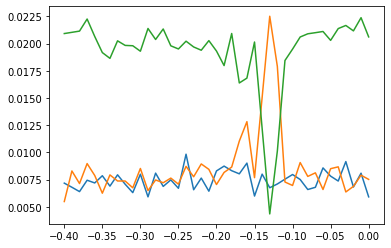

In [767]:
index = np.abs(s_r3).argmax(axis=0)
v_op = np.array([f_r3[:,i][j] for i, j in enumerate(index)])
plt.plot(f_r3,abs(s_r3))
plt.show()

In [768]:
v_op

array([-0.24, -0.13, -0.01])

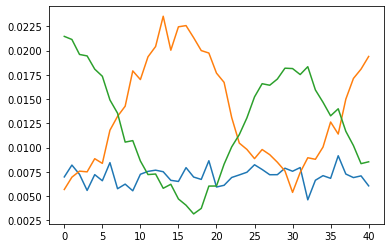

In [771]:
plt.plot(t_r3,abs(s_r3))
plt.show()

# 谱纠正

In [235]:
async def forecast(voltx,volty,s,lenth,stepx,stepy):
    s = np.array(s)
    index = np.argmax(s,axis=1)
    voltx1 = [voltx[i] for i in index]
    p1 = np.polyfit(voltx1,volty,1)
    print(p1)
    #y = p1[0]*voltx + p1[1]
    x_next = (volty[-1]+stepy-p1[1])/p1[0]
    print(x_next)
    i = np.abs(voltx - x_next).argmin()
    if i<3 or i>lenth-3:
        print('i=%d error'%i)
        sys.exit()
    return np.linspace(-3*stepx,3*stepx,7)+x_next,p1,i

In [236]:
async def singlespec(voltx,base,num):
    wf = WF(t_list)
    
    for i in voltx:
        sample_x = wf.square_wave(t_end=[89900],width=[800],height=[i])
        await awg.update_waveform(sample_x,name='voltx')
        time.sleep(3)
        ch_A, ch_B = await ats.getIQ()
        s = ch_A.mean(axis=0) + 1j*ch_B.mean(axis=0)
        theta = np.angle(s) - np.angle(base)
        base *= np.exp(1j*theta)
        yield [i]*num, s-base

In [237]:
p1,x=[],0
async def spec_cali(voltx,volty,pi_len,num,tag):
    global p1,x
    wf = WF(t_list)
    sample_pi = wf.square_wave(t_end=[89800],width=[pi_len],height=[1])
    await awg.update_marker(name='Readout_Q',mk1=sample_pi)    

    j, v, s,circle = 0, [], [],0
    voltx1,stepx,stepy,lenth = voltx,(max(voltx)-min(voltx))/(len(voltx)-1),(max(volty)-min(volty))/(len(volty)-1),len(voltx)
    for i in volty:
        j += 1
        if j > 3 :
            voltx1,p,circle = await forecast(voltx,v,s,lenth,stepx,stepy)
            p1.append(p)
        sample_y = wf.square_wave(t_end=[89900],width=[800],height=[i])
        await awg.update_waveform(sample_y,name='volty')
        time.sleep(3)
        job = Job(singlespec, (voltx1, base, num),no_bar=False,auto_save=False,tags=[tag],comment="1D_%d"%num,max=len(voltx1))
        f_ss, s_ss = await job.done()
        if len(voltx1)<lenth:                      
            a = np.zeros(lenth)             
            a[circle-3:circle+4] = s_ss[:,0]             
            s_ss = a
        v.append(i)
        s.append([np.abs(s_ss[:,0][i]) for i in range(len(s_ss[:,0]))])
        x=s 
        yield [i]*num, voltx.reshape(lenth,1), s_ss.reshape(lenth,1)

In [238]:
voltx,volty,f_ex,power,pi_len,num,tag = np.linspace(-1,1,51),np.linspace(0,0.2,21),f_rabi,-3,t_pi,n,'old_crossover_q12'
await psg_ex.setValue('Frequency',f_ex)
await psg_ex.setValue('Power',power)
job = Job(spec_cali, (voltx,volty,pi_len,num,tag),no_bar=False,auto_save=True,tags=[tag],comment="2D_%d"%num,max=len(volty))
volty,voltx,s_sc = await job.done() 
save('spec_cali',tag,row=volty,col=voltx,s=s_sc,tags=tag,comment="2D_%d"%num)

Output()

TypeError: cannot unpack non-iterable NoneType object

In [53]:
index = np.argmax(np.abs(x),axis=1)
index

array([24, 25, 24], dtype=int64)

In [54]:
help(np.polyfit)

Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,) or (M, K)
        y-coordinates of the sample points. Several data sets of sample
        points sharing the same x-coordinates can be fitted at once by
        passing in a 2D-array that contains one dataset per column.
    deg : int
        Degree of the fitting po

# JPA

## 开关JPA

In [16]:
async def jpa_switch(state='OFF'):
    if state == 'ON':
        await psg_pump.setValue('Output','ON')
        await psg_pump.setValue('Frequency',(jpa.f_ex))
        await psg_pump.setValue('Power',jpa.power_ex)
        await dc03.DC(jpa.bias)
    if state == 'OFF':
        await psg_pump.setValue('Output','OFF')
        await dc03.DC(0)

In [17]:
await jpa_switch('ON')

In [219]:
async def measure(tag):
    '''
    await psg_pump.setValue('Output','OFF')
    await psg_ex.setValue('Output','OFF')
    time.sleep(1)
    ch_A, ch_B = await ats.getIQ()
    s_off_0 = ch_A + 1j*ch_B
    await psg_ex.setValue('Output','ON')
    time.sleep(1)
    ch_A, ch_B = await ats.getIQ()
    s_off_1 = ch_A + 1j*ch_B
    '''
    #JPA ON
    #await psg_pump.setValue('Output','ON')
    await psg_ex.setValue('Output','OFF')
    time.sleep(1)
    ch_A, ch_B = await ats.getIQ()
#     Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
#     theta0 = np.angle(Am) - np.angle(Bm)
#     ch_B *= np.exp(1j*theta0)
    s_on_0 = ch_A + 1j*ch_B
    #s_on_0 = ch_A + 1j*ch_B
    await psg_ex.setValue('Output','ON')
    time.sleep(1)
    ch_A, ch_B = await ats.getIQ()
#     Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
#     theta0 = np.angle(Am) - np.angle(Bm)
#     ch_B *= np.exp(1j*theta0)
    s_on_1 = ch_A + 1j*ch_B
        
    #s_on_1 = ch_A + 1j*ch_B
    #save(''.join((tag,'_','split_state_jpaoff')),row=s_off_0,col=s_off_1,s=None,tags=tag,comment="1D_%d"%num)
    save('JPA',''.join((tag,'_','split_state_jpaon')),row=s_on_0,col=s_on_1,s=1,tags=tag,comment="1D_%d"%num)
    return  s_on_0, s_on_1 
    #return s_off_0, s_off_1, s_on_0, s_on_1
        

In [220]:
def boundary(x,y,k,x0,y0):
    if y-y0-k*(x-x0)>0:
        return 1
    elif y-y0-k*(x-x0)<0:
        return 0
    else:
        return 'online'

In [221]:
await ats_setup(delta, repeats=5000, awg = 0)

In [725]:
delta

array([1.4436e+08, 1.3116e+08, 1.2048e+08, 1.0560e+08, 8.7880e+07,
       7.5920e+07, 6.2520e+07, 5.0040e+07, 3.5180e+07, 2.0960e+07])

In [222]:

await psg_lo.setValue('Output','ON')
s_on_0, s_on_1 = await measure('tomo')

<IPython.core.display.Javascript object>


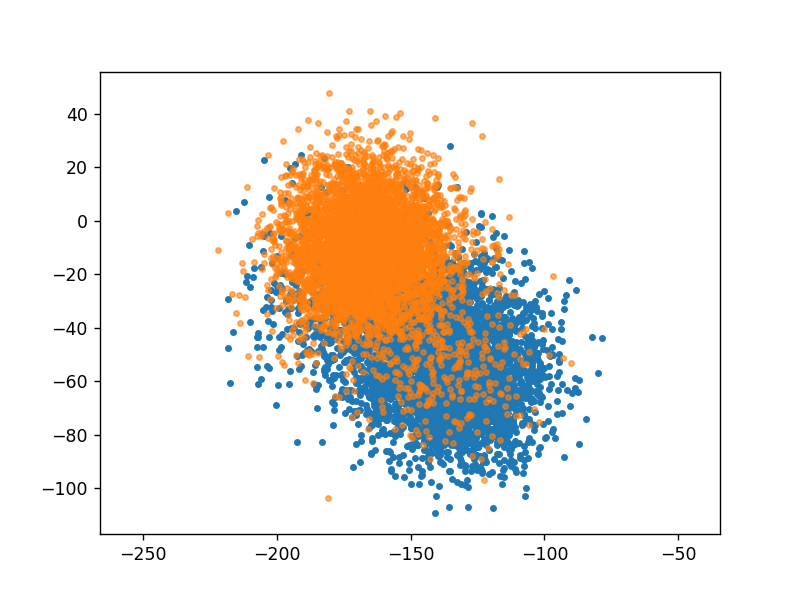

In [223]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.real(s_on_0[:, 0]), np.imag(s_on_0[:, 0]), '.')
ax.plot(np.real(s_on_1[:, 0]), np.imag(s_on_1[:, 0]), '.',alpha=0.6)
#ax.plot(np.real(s_on_0),line(np.real(s_on_0),k,x0,y0))
#ax.set_ylim([-0.25,0.25])
ax.axis('equal')
plt.show()

In [224]:
from sklearn.cluster import KMeans

S = list(s_on_0[:,0]) + list(s_on_1[:,0])
S = np.array(S)
x,z = np.real(S), np.imag(S)
d = list(zip(x,z))
d = np.mat(d)

kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)

kmeans.fit(d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.001, verbose=0)

<IPython.core.display.Javascript object>


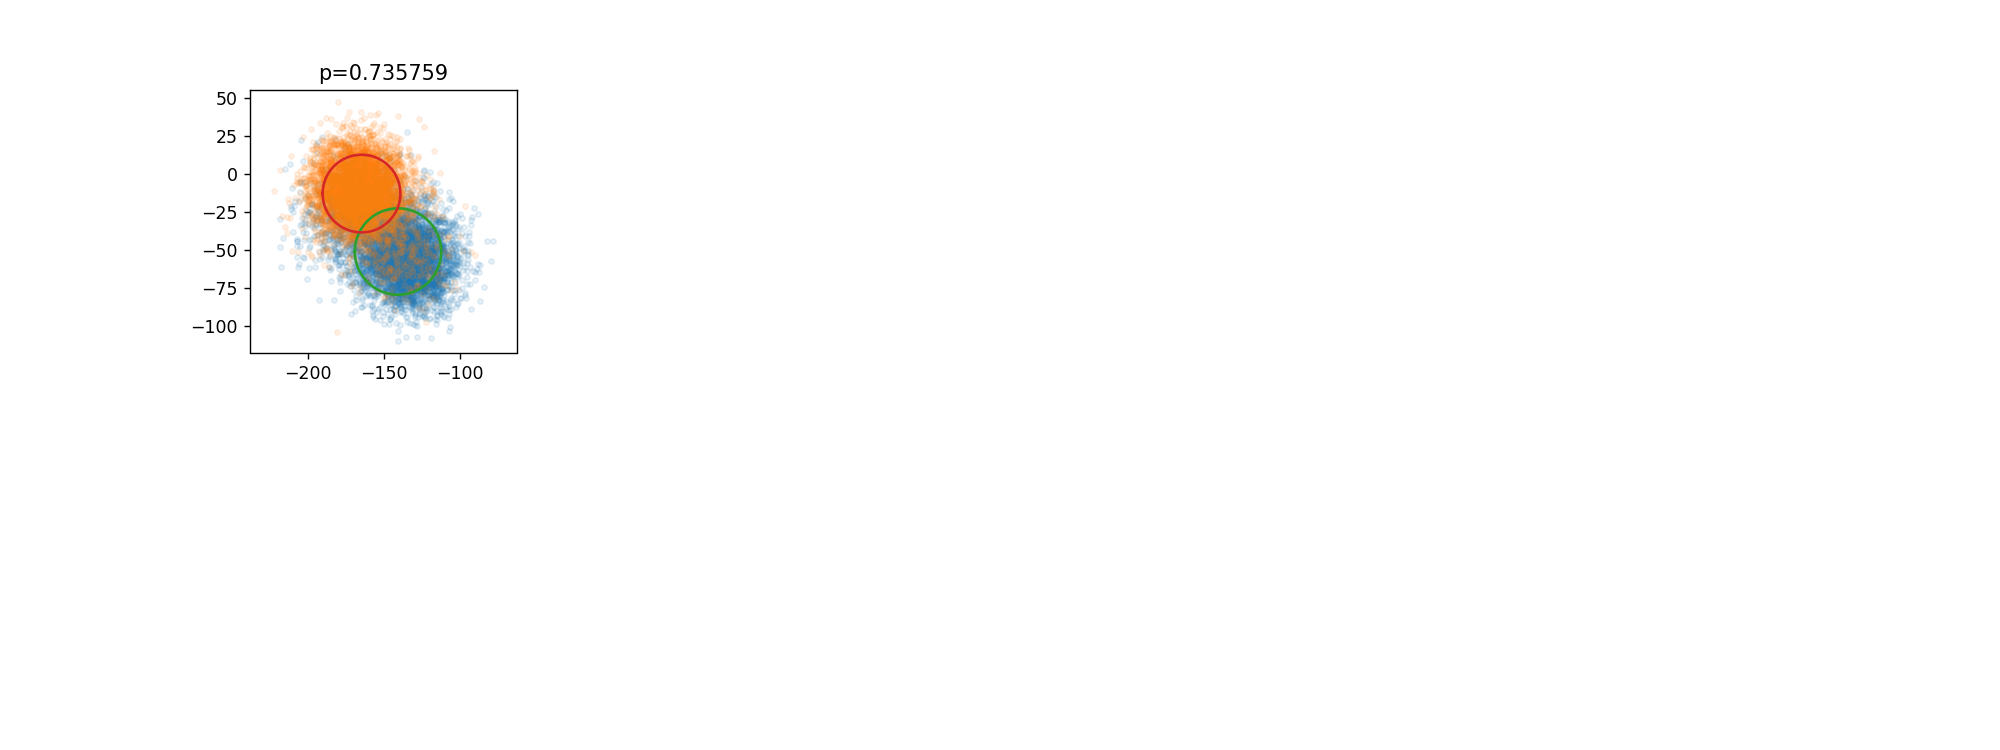

IndexError: index 1 is out of bounds for axis 1 with size 1

In [225]:
fig = plt.figure(figsize=(16,6))

def plotCircle(ax, s):
    c = np.mean(s)
    r = np.std(s)
    t = np.linspace(-1,1,1001)*np.pi
    x,y = r*np.cos(t)+np.real(c), r*np.sin(t)+np.imag(c)
    ax.plot(x,y)

    
def visability(s0,s1):
    c0, c1 = np.mean(s0), np.mean(s1)
    s0 = s0 / ((c1-c0)/np.abs(c1-c0))
    s1 = s1 / ((c1-c0)/np.abs(c1-c0))
    s0 = np.real(s0)
    s1 = np.real(s1)
    bins = np.linspace(np.min(np.r_[s0,s1]), np.max(np.r_[s0,s1]), 61)
    y0,_ = np.histogram(s0, bins=bins)
    y1,_ = np.histogram(s1, bins=bins)
    return np.max(np.cumsum(y0)/np.sum(y0) - np.cumsum(y1)/np.sum(y1))
    
for i in range(10):
    x1,z1 = np.real(s_on_1[:,i]), np.imag(s_on_1[:,i])
    d1 = list(zip(x1,z1))
    d1 = np.mat(d1)
    y1 = kmeans.predict(d1)
    ax = fig.add_subplot(2, 5, i + 1)
    ax.plot(np.real(s_on_0[:, i]), np.imag(s_on_0[:, i]), '.', alpha=0.1)
    ax.plot(np.real(s_on_1[:, i]), np.imag(s_on_1[:, i]), '.', alpha=0.1)
    plotCircle(ax, s_on_0[:, i])
    plotCircle(ax, s_on_1[:, i])
    ax.set_title('p=%f'%(visability(s_on_0[:, i],s_on_1[:, i])))
    #ax.plot(np.real(s_on_0),line(np.real(s_on_0),k,x0,y0))
    #ax.set_ylim([-0.25,0.25])
    ax.axis('equal')
plt.show()

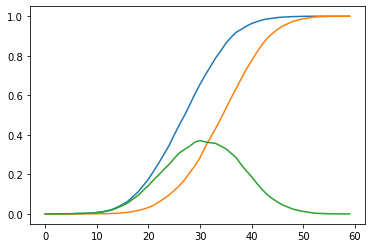

In [527]:
def plotVisability(s0,s1):
    c0, c1 = np.mean(s0), np.mean(s1)
    s0 = s0 / ((c1-c0)/np.abs(c1-c0))
    s1 = s1 / ((c1-c0)/np.abs(c1-c0))
    s0 = np.real(s0)
    s1 = np.real(s1)
    bins = np.linspace(np.min(np.r_[s0,s1]), np.max(np.r_[s0,s1]), 61)
    y0,_ = np.histogram(s0, bins=bins)
    y1,_ = np.histogram(s1, bins=bins)
    plt.plot(np.cumsum(y0)/np.sum(y0))
    plt.plot(np.cumsum(y1)/np.sum(y0))
    plt.plot(np.cumsum(y0)/np.sum(y0) - np.cumsum(y1)/np.sum(y1))
    
i = 0
plotVisability(s_on_0[:, i], s_on_1[:, i])

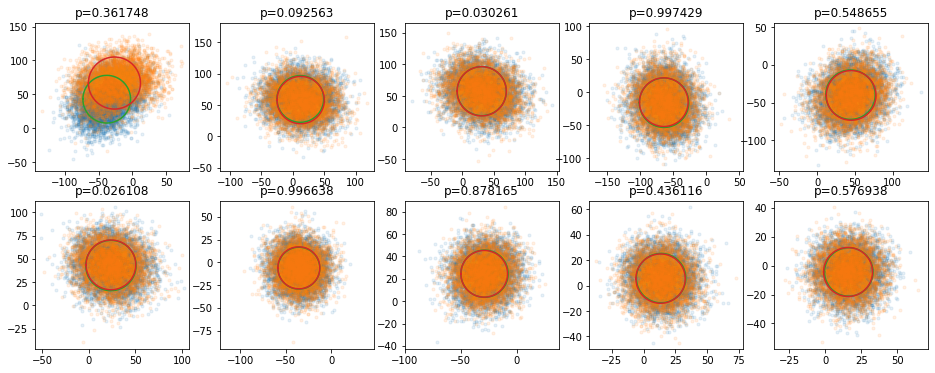

In [528]:
fig = plt.figure(figsize=(16,6))

for i in range(10):
    x1,z1 = np.real(s_on_1[:,i]), np.imag(s_on_1[:,i])
    d1 = list(zip(x1,z1))
    d1 = np.mat(d1)
    y1 = kmeans.predict(d1)
    ax = fig.add_subplot(2, 5, i + 1)
    ax.plot(np.real(s_on_0[:, i]), np.imag(s_on_0[:, i]), '.', alpha=0.1)
    ax.plot(np.real(s_on_1[:, i]), np.imag(s_on_1[:, i]), '.', alpha=0.1)
    plotCircle(ax, s_on_0[:, i])
    plotCircle(ax, s_on_1[:, i])
    ax.set_title('p=%f'%(list(y1).count(1)/len(y1)))
    #ax.plot(np.real(s_on_0),line(np.real(s_on_0),k,x0,y0))
    #ax.set_ylim([-0.25,0.25])
    ax.axis('equal')
plt.show()

In [710]:
await psg_lo.setValue('Frequency',6.649e9)

0.47933148734177217


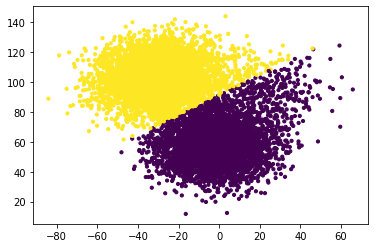

In [671]:
from sklearn.cluster import KMeans

S = list(s_on_0) + list(s_on_1)
S = np.array(S)
x,z = np.real(S[:,0]), np.imag(S[:,0])
d = list(zip(x,z))
d = np.mat(d)

kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)

kmeans.fit(d)

y = kmeans.predict(d)
print(list(y).count(1)/len(y))
plt.scatter(x,z,c=y,s=10)
plt.show()

0.9278085443037974
0.8864715189873418


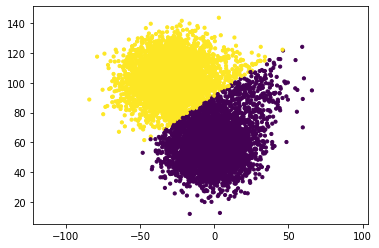

In [673]:
x1,z1 = np.real(s_on_1[:,0]), np.imag(s_on_1[:,0])
d1 = list(zip(x1,z1))
d1 = np.mat(d1)
y1 = kmeans.predict(d1)
print(list(y1).count(0)/len(y1))
x2,z2 = np.real(s_on_0[:,0]), np.imag(s_on_0[:,0])
d2 = list(zip(x2,z2))
d2 = np.mat(d2)
y2 = kmeans.predict(d2)
print(list(y2).count(1)/len(y2))
plt.scatter(x1,z1,c=y1,s=10)
plt.scatter(x2,z2,c=y2,s=10)
plt.axis('equal')
plt.show()

0.9258306962025317
0.8825158227848101


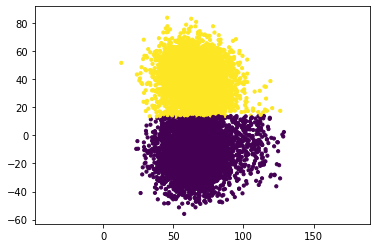

In [664]:
x1,z1 = np.real(s_on_1[:,0]), np.imag(s_on_1[:,0])
d1 = list(zip(x1,z1))
d1 = np.mat(d1)
y1 = kmeans.predict(d1)
print(list(y1).count(0)/len(y1))
x2,z2 = np.real(s_on_0[:,0]), np.imag(s_on_0[:,0])
d2 = list(zip(x2,z2))
d2 = np.mat(d2)
y2 = kmeans.predict(d2)
print(list(y2).count(1)/len(y2))
plt.scatter(x1,z1,c=y1,s=10)
plt.scatter(x2,z2,c=y2,s=10)
plt.axis('equal')
plt.show()

In [94]:
len(y1)

5056

In [151]:
def line(x,k_1,x0_1,y0_1):
        return y0_1+k_1*(x-x0_1)  
def center_f(s_0,s_1):
    l = len(s_0)
    l0, l1 = np.abs(s_0-np.mean(s_0)), np.abs(s_1-np.mean(s_1))
    weight0, weight1 = 1/np.std(l0)/np.sqrt(2*np.pi)*np.exp(-l0**2/np.std(l0)**2/2), 1/np.std(l1)/np.sqrt(2*np.pi)*np.exp(-l1**2/np.std(l1)**2/2)
    #weight0, weight1 = (1/l0)/np.max(1/l0), (1/l1)/np.max(1/l1)
    #weight0, weight1 = np.ones(l), np.ones(l)
    sm0, sm1 = np.average(s_0, weights=weight0), np.average(s_1, weights=weight1)
    center = (sm0 + sm1) / 2
    x0, y0 = np.real(center), np.imag(center)
    r = sm0 - sm1
    k = -np.real(r) / np.imag(r)
    return center, x0, y0, r, k, sm0, sm1

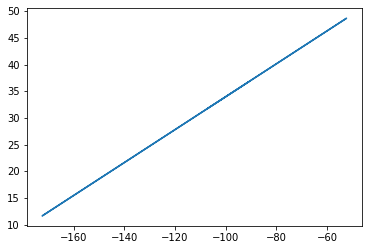

In [152]:
center, x0, y0, r, k, sm0, sm1 = center_f(s_on_0,s_on_1)
plt.plot(np.real(s_on_1),line(np.real(s_on_1),k,x0,y0))
plt.show()

In [153]:

l = len(s_on_1)
p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
lenth = len(p01) - p01.count('online')
pop_z = p01.count(1) / lenth

In [154]:
pop_z

0.7733386075949367

In [175]:
from qulab.math.qst import transformList, acquireVFromData, vToRho

N = 1

for trans in transformList(N):
    print(trans)
    
v = acquireVFromData(N, np.array([pop_z, pop_x_test, pop_y_test]))
rho = vToRho(v)
rho

('I',)
('X',)
('Y',)


array([[ 0.54707278+0.j        , -0.32436709+0.08959652j],
       [-0.32436709-0.08959652j,  0.45292722+0.j        ]])

In [167]:
pop_x_test

0.5895965189873418

In [177]:
pop_y_test

0.8243670886075949

In [150]:
pop_z

0.45292721518987344

In [108]:
pop_y

0.8188291139240507

In [119]:
pop_x

0.3403876582278481

In [162]:
pop_x

0.3403876582278481

In [145]:
pop_x, pop_y = pop_y, pop_x
rho_00, rho_01, rho_10, rho_11 = (1+pop_z)/2, (pop_x-1j*pop_y)/2, (pop_x+1j*pop_y)/2, (1-pop_z)/2

In [146]:
data = np.array([[rho_00,rho_01],[rho_10,rho_11]])
data

array([[0.72646361+0.j        , 0.17019383-0.40941456j],
       [0.17019383+0.40941456j, 0.27353639+0.j        ]])

In [143]:
data.T

array([[0.72646361+0.j        , 0.        +0.57960839j],
       [0.        -0.57960839j, 0.27353639+0.j        ]])

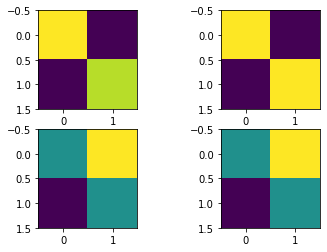

0.5895965189873419


In [176]:
#rho = np.array([[rho_00,rho_01],[rho_10,rho_11]])
#rho = rho.T
plt.subplot(221)
plt.imshow(np.real(rho),interpolation='nearest')
plt.subplot(223)
plt.imshow(np.imag(rho),interpolation='nearest')

rho_id = np.array([
    [1,1j],
    [-1j,1]])/2
plt.subplot(222)
plt.imshow(np.real(rho_id),interpolation='nearest')
plt.subplot(224)
plt.imshow(np.imag(rho_id),interpolation='nearest')
plt.show()

print(np.real(np.trace(rho@rho_id)))

In [135]:
rho@rho_id

array([[ 0.14685522+0.j        ,  0.        +0.14685522j],
       [ 0.        +0.30607199j, -0.30607199+0.j        ]])

# IQ_Mixer_optimize

## 本征泄露

## 镜像抑制

In [ ]:
async def modulation_read(awg,delta,n,phi):
    #t_list = np.linspace(0,100000,250000)

    f, phi, t_end, width, height = [delta], [phi], [[91000]], [[1000]], [[1]]
    wf = WF(t_list)
    await awg.create_waveform(name='Readout_Q', length=len(t_list), format=None)
    await awg.create_waveform(name='Readout_I', length=len(t_list), format=None)
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_Q')
    
    f, phi, t_end, width, height = [delta], [[np.pi/2]*n], [[91000]], [[1000]], [[1]]
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_I')
    
    sample = wf.square_wave(t_end=[91180],width=[1000],height=[1])
    await awg.update_marker(name='Readout_Q',mk1=sample)
    
    time.sleep(5)
    
await modulation_read(awg133,delta,n)

# 关闭仪器

In [14]:
async def close(inst):
    for i,j in enumerate(inst):
        #print(i)
        if i < 11:
            await j.DC(0)
        else:
            await j.setValue('Output','OFF')

In [45]:
inst = [dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_ex,psg_lo,psg_pump]
#inst = [dc02,dc03,dc07,dc08,dc15,psg_ex,psg_lo,psg_pump]
await close(inst)

# 设置衰减器

In [98]:
import serial

ser = serial.Serial("com7", baudrate=115200, parity='N',bytesize=8, stopbits=1, timeout=1) 
#com3对应α测量路线，com7对应β测量路线,com12对应ch4
ser.write(b'ATT?\n')
x = ser.readline().decode().split('\r''\n')
print('ATT',x[0])

ATT 09.0


In [99]:
att = 11#衰减数

if ser.isOpen():    # make sure port is open     
    print(ser.name + ' open...')
    ser.write(b'*IDN?\n')
    x = ser.readline().decode().split('\r''\n')
    print(x[0])
    ser.write(b'ATT %f\n'%att)
    time.sleep(1)
    ser.write(b'ATT?\n')
    x = ser.readline().decode().split('\r''\n')
    print('ATT',x[0])
ser.close()

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 11.0


In [35]:
async def updateWaveform(t_run, op='Z', during=75e-9, shift=-50e-9, Delta=80e6):
    if op == 'Z':
        X, Y = 0, 0
    elif op == 'X':
        X,Y = genXY(during, 0, shift, Delta)
    else:
        X,Y = genXY(during, np.pi/2, shift, Delta)
    
#     lo = Expi(2*np.pi*Delta,2*np.pi*2e6*t_run)
#     init = CosPulse(0.5*during) << 0.75*during             #初始化量子态
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points1 = wav.generateData(sample_rate)
#     lo = Expi(2*np.pi*Delta)
#     init = CosPulse(0.5*during) << (1.25*during + t_run)
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points2 = wav.generateData(sample_rate)
#     points = points1+points2
    lo = Expi(2*np.pi*Delta)
    init = CosPulse(0.5*during) << 0.75*during
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points2 = wav.generateData(sample_rate)
    points = points2
    
    I, Q = np.real(points)+X, np.imag(points)+Y
    
    await awg.create_waveform(f'ex_I_{op}',len(I))
    await awg.create_waveform(f'ex_Q_{op}',len(Q))
    await awg.update_waveform(I, f'ex_I_{op}')
    await awg.update_waveform(Q, f'ex_Q_{op}')

[[1], [1], [1]]

# Tomography

In [42]:
from qulab.waveform import CosPulse, Expi, DC, Step
from qulab.math.qst import transformList, acquireVFromData, vToRho

t_range = (-100e-6, 100e-6)
sample_rate = 2.5e9

def genReadout(flist = delta, readoutLen=1e-6, shift=0):
    lo = 0
    for f in flist:
        lo += Expi(2*np.pi*f)
    lo /= len(flist)
    m = Step(1e-9) - (Step(1e-9) >> readoutLen)
    
    wav = m*lo
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    mk = DC(1,1e-6) >> 180e-9
    mk.set_range(*t_range)
    return np.real(points), np.imag(points), mk.generateData(sample_rate).astype(np.int)


#     pi_2_pulse_1 = Expi(Delta, 0) * (CosPulse(pi_2_len) << (t + pi_2_len/2))
#     pi_2_pulse_2 = Expi(Delta, alpha) * (CosPulse(pi_2_len) << (pi_2_len/2))

#     xy_wav = pi_2_pulse_1 + pi_2_pulse_2

def genXY(during, phi, shift, Delta=80e6):
    lo = Expi(2*np.pi*Delta, phi)
    m = CosPulse(during/2) << during/4
    wav = (m >> shift) * lo
    wav.set_range(*t_range)
    points = wav.generateData(sample_rate)
    return np.real(points), np.imag(points)

async def updateWaveform(t_run, op='Z', during=75e-9, shift=-50e-9, Delta=80e6):
    if op == 'Z':
        X, Y = 0, 0
    elif op == 'X':
        X,Y = genXY(during, 0, shift, Delta)
    else:
        X,Y = genXY(during, np.pi/2, shift, Delta)
    
#     lo = Expi(2*np.pi*Delta,2*np.pi*2e6*t_run)
#     init = CosPulse(0.5*during) << 0.75*during             #初始化量子态
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points1 = wav.generateData(sample_rate)
#     lo = Expi(2*np.pi*Delta)
#     init = CosPulse(0.5*during) << (1.25*during + t_run)
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points2 = wav.generateData(sample_rate)
#     points = points1+points2
    lo = Expi(2*np.pi*Delta)
    init = CosPulse(0.5*during) << 0.75*during
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points2 = wav.generateData(sample_rate)
    points = points2
    
    I, Q = np.real(points)+X, np.imag(points)+Y
    
    await awg.create_waveform(f'ex_I_{op}',len(I))
    await awg.create_waveform(f'ex_Q_{op}',len(Q))
    await awg.update_waveform(I, f'ex_I_{op}')
    await awg.update_waveform(Q, f'ex_Q_{op}')
    
async def updateReadout():
    I,Q,mk = genReadout()
    await awg.create_waveform('Read_I',len(I))
    await awg.create_waveform('Read_Q',len(Q))
    await awg.update_waveform(I, 'Read_I')
    await awg.update_waveform(Q, 'Read_Q')
    await awg.update_marker('Read_Q', mk1=mk)

#await updateReadout()
# await updateWaveform(104e-9,'Z')
# await updateWaveform(104e-9,'X')
# await updateWaveform(104e-9,'Y')

In [43]:
async def updateWaveform_bloch(t_run, op='Z', during=45e-9, shift=-50e-9, Delta=80e6):
    t_range = (-2e-6, 2e-6)
    sample_rate = 2.5e9
    if op == 'Z':
        X, Y = 0, 0
    elif op == 'X':
        X,Y = genXY(during, 0, shift, Delta)
    else:
        X,Y = genXY(during, np.pi/2, shift, Delta)
    
#     lo = Expi(2*np.pi*Delta,2*np.pi*2e6*t_run)
#     init = CosPulse(0.5*during) << 0.75*during             #初始化量子态
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points1 = wav.generateData(sample_rate)
#     lo = Expi(2*np.pi*Delta)
#     init = CosPulse(0.5*during) << (1.25*during + t_run)
#     wav = (init >> shift) * lo
#     wav.set_range(*t_range)
#     points2 = wav.generateData(sample_rate)
#     points = points1+points2
    lo = Expi(2*np.pi*Delta)
    init = CosPulse(during) << (during)
    wav = (init >> shift) * lo
    wav.set_range(*t_range)
    points2 = wav.generateData(sample_rate)
    points = points2
    
    I, Q = np.real(points)+X, np.imag(points)+Y
    
    await awg.create_waveform(f'ex_I_{op}',len(I))
    await awg.create_waveform(f'ex_Q_{op}',len(Q))
    await awg.update_waveform(I, f'ex_I_{op}')
    await awg.update_waveform(Q, f'ex_Q_{op}')

In [1923]:
async def pi_test(t):
    
    for i in t:
        ret = []
        await updateWaveform_bloch(i/1e9,'Z')
        await updateWaveform_bloch(i/1e9,'X')
        await updateWaveform_bloch(i/1e9,'Y')
        time.sleep(4)
        
        await awg.use_waveform('ex_I_Z',ch=3)
        await awg.use_waveform('ex_Q_Z',ch=4)
        time.sleep(4)
        chA, chB = await ats.getIQ()
        ret.append([chA, chB])

        await awg.use_waveform('ex_I_Y',ch=3)
        await awg.use_waveform('ex_Q_Y',ch=4)
        time.sleep(4)
        chA, chB = await ats.getIQ()
        ret.append([chA, chB])

        await awg.use_waveform('ex_I_X',ch=3)
        await awg.use_waveform('ex_Q_X',ch=4)
        time.sleep(4)
        chA, chB = await ats.getIQ()
        ret.append([chA, chB])
        
        p=[]
        for i in range(3):
            chA,chB = ret[i]
            Am, Bm = chA.mean(axis=0),chB.mean(axis=0)
            theta0 = np.angle(Am) - np.angle(Bm)
            chB *= np.exp(1j*theta0)
            s_on_1 = chA + chB
            l = len(s_on_1)
            p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
            lenth = len(p01) - p01.count('online')
            pop_y_test = p01.count(1) / lenth
            p.append(pop_y_test)
        pop_z, pop_y, pop_x = p[0], p[1], p[2]
        rx, ry, rz = 1-2*pop_x, 1-2*pop_y, 1-2*pop_z
        yield [rx],[ry],[rz]

In [1924]:
t = np.linspace(0,1200,121,dtype=int)
job = Job(pi_test,(t,),auto_save=True)
result = await job.done()
    

Output()

In [408]:
ret = []
await awg.use_waveform('ex_I_Z',ch=3)
await awg.use_waveform('ex_Q_Z',ch=4)
await asyncio.sleep(5)
chA, chB = await ats.getIQ()
ret.append([chA, chB])

await awg.use_waveform('ex_I_Y',ch=3)
await awg.use_waveform('ex_Q_Y',ch=4)
await asyncio.sleep(5)
chA, chB = await ats.getIQ()
ret.append([chA, chB])

await awg.use_waveform('ex_I_X',ch=3)
await awg.use_waveform('ex_Q_X',ch=4)
await asyncio.sleep(5)
chA, chB = await ats.getIQ()
ret.append([chA, chB])

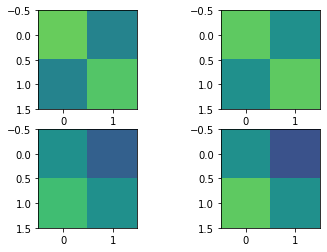

0.8850870253164556


In [409]:
def boundary(x,y,k,x0,y0):
    if y-y0-k*(x-x0)<0:
        return 1
    elif y-y0-k*(x-x0)>0:
        return 0
    else:
        return 'online'
    
p=[]
for i in range(3):
    chA,chB = ret[i]
    s_on_1 = chA+1j*chB
    
    l = len(s_on_1)
    p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
    lenth = len(p01) - p01.count('online')
    pop_y_test = p01.count(1) / lenth
    p.append(pop_y_test)

# from qulab.math.qst import transformList, acquireVFromData, vToRho

# N = 1

# for trans in transformList(N):
#     print(trans)
    
# v = acquireVFromData(N, np.array(p))
# rho = vToRho(v)
pop_z, pop_y, pop_x = p[0], p[1], p[2]
rho_00, rho_01 = 1 - pop_z, (2*pop_x - 2j*pop_y - 1 + 1j) / 2j
rho_10, rho_11 = (1 + 1j - 2*pop_x - 2j*pop_y) / 2j, pop_z
rho = np.array([[rho_00,rho_01],[rho_10,rho_11]])

plt.subplot(221)
plt.imshow(np.real(rho),interpolation='nearest', vmin=-1, vmax=1)
plt.subplot(223)
plt.imshow(np.imag(rho),interpolation='nearest', vmin=-1, vmax=1)

rho_id = np.array([            #对应的旋转轴是1/2*（sigma_x+sigma_y)
    [1,-1j],
    [1j,1]])/2

# rho_id = np.array([
#     [0,0],
#     [0,1]])
plt.subplot(222)
plt.imshow(np.real(rho_id),interpolation='nearest', vmin=-1, vmax=1)
plt.subplot(224)
plt.imshow(np.imag(rho_id),interpolation='nearest', vmin=-1, vmax=1)
plt.show()

print(np.real(np.trace(rho@rho_id)))

In [194]:
pop_z

0.43473101265822783

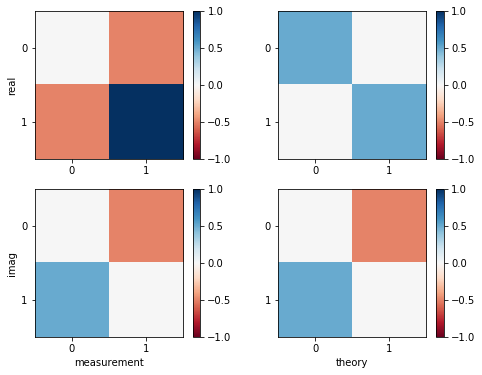

1.0


In [903]:
p=[]
for i in range(3):
    chA,chB = ret[i]
    s_on_1 = chA+1j*chB
    
    l = len(s_on_1)
    p01 = list(map(boundary,np.real(s_on_1),np.imag(s_on_1),[k]*l,[x0]*l,[y0]*l))
    lenth = len(p01) - p01.count('online')
    pop_y_test = p01.count(1) / lenth
    p.append(pop_y_test)

# from qulab.math.qst import transformList, acquireVFromData, vToRho

# N = 1

# for trans in transformList(N):
#     print(trans)
    
# v = acquireVFromData(N, np.array(p))
# rho = vToRho(v)
pop_z, pop_y, pop_x = p[0], p[1], p[2]
rho_00, rho_01 = 1 - pop_z, (2*pop_x - 2j*pop_y - 1 + 1j) / 2j
rho_10, rho_11 = (1 + 1j - 2*pop_x - 2j*pop_y) / 2j, pop_z
rho = np.array([[rho_00,rho_01],[rho_10,rho_11]])
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.imshow(np.real(rho),cmap='RdBu',interpolation='nearest', vmin=-1, vmax=1)
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylim([1.5,-0.5])
plt.ylabel('real')
plt.colorbar()
plt.subplot(223)
plt.imshow(np.imag(rho),cmap='RdBu',interpolation='nearest', vmin=-1, vmax=1)
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylim([1.5,-0.5])
plt.xlabel('measurement')
plt.ylabel('imag')
plt.colorbar()

rho_id = np.array([
    [1,-1j],
    [1j,1]])/2

# rho_id = np.array([
#     [0,0],
#     [0,1]])
plt.subplot(222)
plt.imshow(np.real(rho_id),cmap='RdBu',interpolation='nearest', vmin=-1, vmax=1)
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylim([1.5,-0.5])
plt.colorbar()
plt.subplot(224)
plt.imshow(np.imag(rho_id),cmap='RdBu',interpolation='nearest', vmin=-1, vmax=1)
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylim([1.5,-0.5])
plt.xlabel('theory')
plt.colorbar()
plt.show()

print(np.real(np.trace(rho@rho_id)))

In [59]:
rho

array([[ 0.56526899+0.j        , -0.32970728-0.33999209j],
       [-0.32970728+0.33999209j,  0.43473101+0.j        ]])

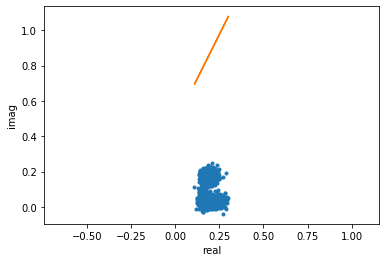

In [904]:
chA, chB = ret[0]
plt.plot(np.real(chA+1j*chB), np.imag(chA+1j*chB), '.')
plt.plot(np.real(chA+1j*chB),line(np.real(chA+1j*chB),k,x0,y0))
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('imag')
plt.show()

In [255]:
from qutip import *

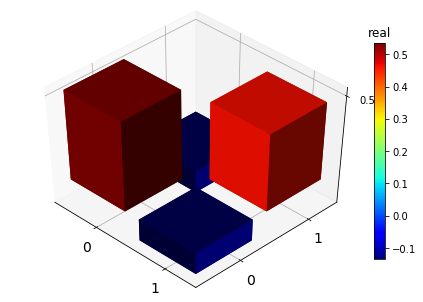

In [257]:

fig, ax = matrix_histogram(np.real(rho))
plt.title('real')
ax.view_init(azim=-45, elev=45)
plt.show()


# Tomo2D

In [101]:
def boundary(x,y,k,x0,y0):
    if y-y0-k*(x-x0)>0:
        return 1
    elif y-y0-k*(x-x0)<0:
        return 0
    else:
        return 'online'


In [1896]:
async def single_t(x,w,num):
    await update(w)
    time.sleep(5)
    a = []
    for j in x:

        ch_A, ch_B = await ats.getIQ()
        s = ch_A + 1j*ch_B
        #a.append(s)
        l = len(s)
        p01 = list(map(boundary,np.real(s),np.imag(s),[k]*l,[x0]*l,[y0]*l))
        lenth = len(p01) - p01.count('online')
        pop = p01.count(1) / lenth
        yield [j]*num, [pop]

In [103]:
async def tomo2D(x,pi_len,y,num,tag):
    wf = WF(t_list)     
    await psg_lo.setValue('Output','ON')     
    await psg_ex.setValue('Output','ON')
    b = []
    for i in y:

        job = Job(single_t,(x,i,num),tags=[tag],auto_save=False,comment="1D_%d"%num, max=len(x))
        v_s, s_s = await job.done()
        #b.append(a)
        yield [i]*num,v_s,s_s

In [109]:
x, power, num, y, pi_len, tag = np.linspace(-150,50,101), 0, 1, np.linspace(-200,200,201),104, 'xue_crossover_q6789'
#await psg_ex.setValue('Power',power)
#await psg_lo.setValue('Frequency',f_lo)
#await psg_ex.setValue('Frequency',f_rabi+80e6)
job = Job(tomo2D,(x,pi_len,y,num,tag),tags=[tag],comment="2D_%d"%num, max=len(y))
t_t, f_t, s_t = await job.done()
save('tomo2D',tag,row=t_t,col=f_t,s=s_t,tags=tag,comment="2D_%d"%num)
await close(inst)

Output()

In [216]:
np.arctan(np.inf)

1.5707963267948966

# Bloch Sphere

In [17]:
import numpy as np  
import matplotlib as mpl  
import matplotlib.pyplot as plt  
from matplotlib import cm  
from mpl_toolkits.mplot3d import Axes3D  
from qutip import *  
from qutip.ipynbtools import version_table 

IndexError: index 1 is out of bounds for axis 0 with size 1

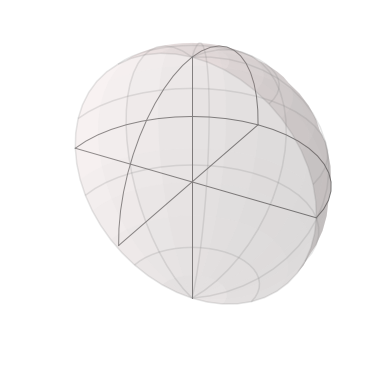

In [45]:
#tlist = np.linspace(-10.0, 10.0, 1500) 
b = Bloch()  
## normalize colors to times in tlist ##  
#nrm = mpl.colors.Normalize(-2,10)  
#colors = cm.cool(nrm(tlist))   
## add data points from expectation values ##  
b.add_points([[0,1,0],[1,0,0],[0.5,0.5,0]],'m')
## customize sphere properties ##  
b.add_vectors([[0,1,0],[1,0,0],[0.5,0.5,0.5]]) 
b.point_color = ['red']  
b.point_marker = ['o']  
b.point_size = [50]   
b.zlpos = [1.1,-1.2]   
b.show()

In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from qutip import *
from qutip.ipynbtools import version_table
%matplotlib inline

In [52]:
delta = 0.5 * 2 * np.pi
v = 2.0 * 2 * np.pi # sweep rate

H0 = delta/2.0 * sigmax()
H1 = v/2.0 * sigmaz()
H = [H0, [H1, 't']]
psi0 = basis(2,0)

sm = destroy(2)
sx=sigmax();
sy=sigmay()
sz=sigmaz()
expt_ops = [sm.dag() * sm,sx,sy,sz]


tlist = np.linspace(-10.0, 10.0, 1500)
expt_list = sesolve(H, psi0, tlist, expt_ops).expect

In [62]:
b = Bloch()
## normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(-2,10)
colors = cm.cool(nrm(tlist))

## add data points from expectation values ##
b.add_points([expt_list[1],
              expt_list[2],
              -expt_list[3]],'m')

## customize sphere properties ##
b.point_color = list(colors)
b.point_marker = ['o']
b.point_size = [20]

b.zlpos = [1.1,-1.2]

b.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000020F6D362558> (for post_execute):


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (0,4) and requested shape (1500,4)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (0,4) and requested shape (1500,4)

<Figure size 360x360 with 1 Axes>

In [54]:
import numpy as np

In [60]:
help(b)

Help on Bloch in module qutip.bloch object:

class Bloch(builtins.object)
 |  Bloch(fig=None, axes=None, view=None, figsize=None, background=False)
 |  
 |  Class for plotting data on the Bloch sphere.  Valid data can be
 |  either points, vectors, or qobj objects.
 |  
 |  Attributes
 |  ----------
 |  
 |  axes : instance {None}
 |      User supplied Matplotlib axes for Bloch sphere animation.
 |  fig : instance {None}
 |      User supplied Matplotlib Figure instance for plotting Bloch sphere.
 |  font_color : str {'black'}
 |      Color of font used for Bloch sphere labels.
 |  font_size : int {20}
 |      Size of font used for Bloch sphere labels.
 |  frame_alpha : float {0.1}
 |      Sets transparency of Bloch sphere frame.
 |  frame_color : str {'gray'}
 |      Color of sphere wireframe.
 |  frame_width : int {1}
 |      Width of wireframe.
 |  point_color : list {["b","r","g","#CC6600"]}
 |      List of colors for Bloch sphere point markers to cycle through.
 |      i.e. By defa

In [61]:
type(b)

qutip.bloch.Bloch

# RTO

In [228]:
from qulab.drivers.AlazarTechDigitizer import Driver
ats = Driver(systemID=1, boardID=1)

In [229]:
ats.set(repeats=0, maxlen=20*60*10000)

for i in range(3*6):
    t = time.strftime('%y%m%d') + '_' + time.strftime("%H%M%S", time.localtime())
    chA, chB = ats.getIQ()
    np.savez(r'D:\QuLabData\row\RTO_%s.npz'%t,chA=chA,chB=chB)

# photon noise

In [1660]:
async def modulation_read_with_photon_noise(awg,delta,n,amp=0.1):
    #t_list = np.linspace(0,100000,250000)

    f, phi, t_end, width, height = [delta], [[0]*n], [[91000]], [[1000]], [[1]]
    wf = WF(t_list)
    await awg.create_waveform(name='Readout_Q', length=len(t_list), format=None)
    await awg.create_waveform(name='Readout_I', length=len(t_list), format=None)
    sample = wf.square_envelope(f,phi,t_end,width,height)
    sample += wf.square_envelope(f,phi,[[90000]],[[100000]],[[amp]])
    await awg.update_waveform(sample,name='Readout_Q')
    
    f, phi, t_end, width, height = [delta], [[np.pi/2]*n], [[91000]], [[1000]], [[1]]
    sample = wf.square_envelope(f,phi,t_end,width,height)
    sample += wf.square_envelope(f,phi,[[90000]],[[100000]],[[amp]])
    await awg.update_waveform(sample,name='Readout_I')
    
    sample = wf.square_wave(t_end=[91180],width=[1000],height=[1])
    await awg.update_marker(name='Readout_Q',mk1=sample)
    
    time.sleep(5)
    
amp=0.2
await modulation_read_with_photon_noise(awg133,delta,n,amp)

In [1678]:
for amp in np.linspace(0, 0.2, 41):
    await modulation_read_with_photon_noise(awg133,delta,n,amp)
    
    ###################################################################
    # Spec
    ###################################################################
    await awg133.use_waveform(name='Readout_I',ch=7)
    await awg133.use_waveform(name='Readout_Q',ch=8)
    await awg133.use_waveform(name='Ex_I',ch=3)
    await awg133.use_waveform(name='Ex_Q',ch=4)
    await awg133.use_waveform(name='z',ch=5)
    print('Setting spectrum paramenters...')
    freq, f_readout, power, num, att_single = np.linspace(3.9,4.1,201)*1e9, f_lo, 10, n, 40
    await psg_lo.setValue('Frequency',f_readout)
    await psg_ex.setValue('Power',power)
    await ats_setup(delta, repeats=500, awg = 0)
    att_setup = op.Att_Setup("COM12")
    att_setup.Att(att_single)
    att_setup.close()
    await modulation_single(awg133,[80e6],n,25000)
    print(num)
    print('Setting spectrum paramenters... Done')
    time.sleep(5)
    job = Job(singlespec, (freq, base, num),tags=['old_crossover_q4'],max=len(freq))
    print('Start spectrum measurement.')
    f_ss, s_ss = await job.done()
    print('Stop spectrum measurement.')
    
    save(f'Spec_{amp}','old_crossover_q4',row=np.array(f_ss),col=np.array(s_ss),s=1,tags=['old_crossover_q4'],comment="1D_%d"%num)
    
    ###################################################################
    # T1
    ###################################################################
    f_qubit, pi_len, t,num, tag, len_data = f_rabi, t_pi, np.linspace(0,80000,501), n, 'old_crossover_q4', 500
    
    await ats_setup(delta, repeats=500, awg = 1)
    att_setup = op.Att_Setup("COM12")
    att_setup.Att(att_rabi)
    att_setup.close()
    await psg_ex.setValue('Power',power)
    await psg_ex.setValue('Frequency',f_qubit+80e6)
    await psg_lo.setValue('Frequency',f_lo)
    
    await awg133.stop()
    time.sleep(5)
    j = 0
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_rabi(awg133,during=pi_len*1e-9, shift=-(i+100)*1e-9, name = name_ch)
    
    await awg133.use_sequence(name='coherence', channels=[4, 3])
    await awg133.use_sequence(name='common_vert', channels=[7,8,5])

    t_addr, z_T1 = [], []
    for i in range(1):
        await awg133.run()
        time.sleep(30)
        t1 = time.time()
        t_addr.append(t1)
        job = Job(T1,(pi_len,t,base,len_data),tags=[tag],avg=True,max=800)
        t_T, s_T = await job.done()
        
    save(f'T1_{amp}',tag,row=np.array(t_T),col=np.array(s_T),s=1,tags=tag,comment="1D_%d"%num)
    
    ###################################################################
    # Ramsey
    ###################################################################
    f_qubit, pi_len, t, num, tag, len_data = f_rabi+80e6, t_pi, np.linspace(0,8000,501), n, 'old_crossover_q4', 500
    j = 0
    await awg133.stop()
    time.sleep(5)

    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_ramsey(awg133,t_run=i/1e9,during=pi_len/1e9, name = name_ch)
        
    await awg133.run()
    await ats_setup(delta, repeats=500, awg = 1)
    time.sleep(30)
    job = Job(Ramsey,(pi_len,base,t,len_data),tags=[tag],max=800,avg=True)
    t_R, s_R = await job.done()
    
    save(f'Ramsey_{amp}',tag,row=t_R,col=s_R,s=1,tags=tag,comment="1D_%d"%num)
    
    ###################################################################
    # SpinEcho
    ###################################################################
    f_qubit, bias, power, pi_len, t, num, tag = f_rabi+5e6, 0.06, -3, t_pi, np.linspace(0,10000,501), n, 'old_crossover_q2'
    j = 0
    await awg133.stop()
    time.sleep(5)
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_spinecho(awg133,t_run=i*1e-9,during=pi_len*1e-9,n_wave=1,name=name_ch)
        
    await awg133.run()
    time.sleep(30)
    job = Job(SpinEcho,(pi_len,t,base,len_data),tags=[tag],comment="1D_%d"%num,max=800,avg=True)
    t_S, s_S = await job.done()
    
    save(f'SpinEcho_{amp}',tag,row=t_S,col=s_S,s=1,tags=tag,comment="1D_%d"%num)

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Setting spectrum paramenters...
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

In [1703]:
import pickle

def saveStatus(fname='D:/status.obj'):
    import sys
    
    status = {}
    
    for k in filter(
        lambda s: s[0] != '_' and not callable(globals()[s]) and
        not isinstance(globals()[s], type(sys)) and not s in ['In', 'Out'],
        globals().keys()):
        try:
            status[k] = pickle.dumps(globals()[k])
        except:
            print(k, type(globals()[k]))
            
    with open(fname, 'wb') as f:
         pickle.dump(status, f)
    
def loadStatus(fname='D:/status.obj'):
    with open(fname, 'rb') as f:
        status = pickle.load(f)
    
    for k, v in status.items():
        globals()[k] = pickle.loads(v)

# flux noise

In [1833]:
for o in tqdm(np.linspace(0.79,0.94,46),desc='flux_noisy'):
    
    await jpa_switch('ON')

    c0, c1, c2 = o*bias_cross[2],o*bias_cross[3],o*bias_cross[4]
    await (globals().get(q3.inst['dc'])).DC(c0+bias_cross1[0]) 
    await (globals().get(q4.inst['dc'])).DC(c1+bias_cross1[1]) 
    await (globals().get(q5.inst['dc'])).DC(c2+bias_cross1[2])
    
    ###################################################################
    # Spec
    ###################################################################
    await awg133.run()
    await awg133.use_waveform(name='Readout_I',ch=7)
    await awg133.use_waveform(name='Readout_Q',ch=8)
    await awg133.use_waveform(name='Ex_I',ch=3)
    await awg133.use_waveform(name='Ex_Q',ch=4)
    #await awg133.use_waveform(name='z',ch=5)
    print('Setting spectrum paramenters...')
    time.sleep(5)
    f_lo, delta, n, f_res, base = await again()
    freq, f_readout, power, num, att_single = np.linspace(3.7,4.05,351)*1e9, f_lo, 10, n, 40
    await psg_lo.setValue('Frequency',f_readout)
    await psg_ex.setValue('Power',power)
    await ats_setup(delta, repeats=500, awg = 0)
    att_setup = op.Att_Setup("COM12")
    att_setup.Att(40)
    att_setup.close()
    await modulation_single(awg133,[80e6],n,25000)
    print(num)
    print('Setting spectrum paramenters... Done')
    job = Job(singlespec, (freq, base, num),tags=['old_crossover_q4'],max=len(freq))
    print('Start spectrum measurement.')
    f_ss, s_ss = await job.done()
    index = np.abs(s_ss).argmax(axis=0)
    f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
    print('Stop spectrum measurement.')
    save(f'Spec_{o}','old_crossover_q4',row=np.array(f_ss),col=np.array(s_ss),s=1,tags=['old_crossover_q4'],comment="1D_%d"%num)
    
    ###################################################################
    # Rabi
    ###################################################################
    
    f_qubit, t,num, tag, len_data = f_rabi, np.linspace(0,100,501), n, 'old_crossover_q4', 500
    
    await ats_setup(delta, repeats=500, awg = 1)
    att_setup = op.Att_Setup("COM12")
    att_setup.Att(15)
    att_setup.close()
    await psg_ex.setValue('Frequency',f_qubit+80e6)
    await psg_lo.setValue('Frequency',f_lo)
    
    await awg133.stop()
    time.sleep(5)
    j = 0
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_rabi(awg133,during=i/1e9, name = name_ch)
    
    await awg133.use_sequence(name='coherence', channels=[4, 3])
    await awg133.use_sequence(name='common_vert', channels=[7,8,5])
    await awg133.run()
    time.sleep(30)
    job = Job(rabi,(t,num,k,data_len),tags=['old_crossover_q4'], max=500, avg=True)
    t_r, s_r = await job.done()
    index = np.abs(s_r[:300]).argmax(axis=0)
    t_pi = np.array([t_r[:,i][j] for i, j in enumerate(index)])

    ###################################################################
    # T1
    ###################################################################
    
    pi_len, t, num, tag, len_data = t_pi, np.linspace(0,80000,501), n, 'old_crossover_q4', 500

    await awg133.stop()
    time.sleep(5)
    j = 0
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_rabi(awg133,during=pi_len*1e-9, shift=-(i+100)*1e-9, name = name_ch)
    await ats_setup(delta, repeats=500, awg = 1)
    await awg133.run()
    time.sleep(30)
    job = Job(T1,(pi_len,t,base,len_data),tags=[tag],avg=True,max=800)
    t_T, s_T = await job.done()
        
    save(f'T1_{o}',tag,row=np.array(t_T),col=np.array(s_T),s=1,tags=tag,comment="1D_%d"%num)
    
    ###################################################################
    # Ramsey
    ###################################################################
    
    pi_len, t, num, tag, len_data = t_pi, np.linspace(0,8000,501), n, 'old_crossover_q4', 500
    j = 0
    await awg133.stop()
    time.sleep(5)

    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_ramsey(awg133,t_run=i/1e9,during=pi_len/1e9, name = name_ch)
        
    await awg133.run()
    await ats_setup(delta, repeats=500, awg = 1)
    time.sleep(30)
    job = Job(Ramsey,(pi_len,base,t,len_data),tags=[tag],max=800,avg=True)
    t_R, s_R = await job.done()
    
    save(f'Ramsey_{o}',tag,row=t_R,col=s_R,s=1,tags=tag,comment="1D_%d"%num)
    
    ###################################################################
    # SpinEcho
    ###################################################################
    pi_len, t, num, tag = t_pi, np.linspace(0,10000,501), n, 'old_crossover_q2'
    j = 0
    await awg133.stop()
    time.sleep(5)
    for i in tqdm(t,desc='sequence'):
        j += 1
        name_ch = [''.join(('coherence_I','%d'%j)),''.join(('coherence_Q','%d'%j))]
        await updateWaveform_spinecho(awg133,t_run=i*1e-9,during=pi_len*1e-9,n_wave=1,name=name_ch)
        
    await awg133.run()
    time.sleep(30)
    job = Job(SpinEcho,(pi_len,t,base,len_data),tags=[tag],comment="1D_%d"%num,max=800,avg=True)
    t_S, s_S = await job.done()
    
    save(f'SpinEcho_{o}',tag,row=t_S,col=s_S,s=1,tags=tag,comment="1D_%d"%num)
    
await close(inst) 

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()

Setting spectrum paramenters...


Output()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 15.0
1
Setting spectrum paramenters... Done


Output()

Start spectrum measurement.
Stop spectrum measurement.
COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 40.0


Output()

Output()

Output()

Output()